![Impressions](https://PixelServer20190423114238.azurewebsites.net/api/impressions/NotebookVM/how-to-use-azureml/deployment/deploy-to-cloud/model-register-and-deploy.png)

# **Cluster and Survival Analysis of Gene Expression Data of Breast Cancer Patients**

#### Shwetha S

In [2]:
import azureml.core
# Check core SDK version number.
print('SDK version:', azureml.core.VERSION)

SDK version: 1.36.0


## Initialize workspace

Create a Workspace object from your persisted configuration.

In [3]:
from azureml.core import Workspace


ws = Workspace.from_config()
print(ws.name, ws.resource_group, ws.location, ws.subscription_id, sep='\n')

shwethasml
finalproject
centralindia
7df024c6-4a46-4509-a862-50dc739bffa2


### **Loading Dataset and Libraries**

In [ ]:
!pip install lifelines
!pip install scikit-survival

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np  
from sklearn import preprocessing
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import os
import io
import statistics
from sklearn.impute import SimpleImputer
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test
from lifelines import KaplanMeierFitter
from sklearn.metrics import silhouette_score
from sklearn.metrics import pairwise_distances
import matplotlib.cm as cm
from sklearn.metrics import davies_bouldin_score
from sklearn.model_selection import ParameterGrid
import sklearn.metrics as metrics
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from scipy import stats


In [6]:
from sklearn.model_selection import train_test_split

In [7]:
from lifelines import KaplanMeierFitter

In [171]:
missing_values = ['na', '--', 'n/a', 'NA', '-']

In [8]:
df= pd.read_csv('METABRIC_RNA_Mutation.csv')  
df.sample(10)

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (678,688,690,692) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,patient_id,age_at_diagnosis,type_of_breast_surgery,cancer_type,cancer_type_detailed,cellularity,chemotherapy,pam50_+_claudin-low_subtype,cohort,er_status_measured_by_ihc,...,mtap_mut,ppp2cb_mut,smarcd1_mut,nras_mut,ndfip1_mut,hras_mut,prps2_mut,smarcb1_mut,stmn2_mut,siah1_mut
1684,7017,36.63,BREAST CONSERVING,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,High,1,claudin-low,4.0,Negative,...,0,0,0,0,0,0,0,0,0,0
1349,5414,61.14,BREAST CONSERVING,Breast Cancer,Breast Invasive Ductal Carcinoma,High,0,LumB,3.0,Positve,...,0,0,0,0,0,0,0,0,0,0
1047,4904,64.30,NaN,Breast Cancer,Breast Invasive Ductal Carcinoma,Moderate,1,claudin-low,3.0,Negative,...,0,0,0,0,0,0,0,0,0,0
1317,5369,66.18,BREAST CONSERVING,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,High,0,LumA,3.0,Positve,...,0,0,0,0,0,0,0,0,0,0
800,4212,45.50,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,Low,0,LumA,3.0,Positve,...,0,0,0,0,0,0,0,0,0,0
258,396,56.45,BREAST CONSERVING,Breast Cancer,Breast Invasive Ductal Carcinoma,High,1,Basal,1.0,Negative,...,0,0,0,0,0,0,0,0,0,0
952,4731,49.43,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,High,1,Her2,3.0,Negative,...,0,0,0,0,0,0,0,0,0,0
1334,5397,61.16,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,High,0,LumA,3.0,Positve,...,0,0,0,0,0,0,0,0,0,0
667,3266,52.91,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,Low,0,LumB,2.0,Positve,...,0,0,0,0,0,0,0,0,0,0
842,4348,61.57,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,Moderate,0,Her2,3.0,Positve,...,0,0,0,0,0,0,0,0,0,0


In [9]:
df.shape

(1904, 693)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1904 entries, 0 to 1903
Columns: 693 entries, patient_id to siah1_mut
dtypes: float64(498), int64(5), object(190)
memory usage: 10.1+ MB


## **EDA AND PREPROCESSING:**

### Renaming columns:

In [11]:
df.rename(columns = {'type_of_breast_surgery': 'surgery_type','her2_status_measured_by_snp6':'her2_next_generation_sequencing','er_status_measured_by_ihc':'er_ihc','cancer_type_detailed': 'summary'},inplace=True)

In [12]:
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/anaconda/envs/azureml_py36/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/anaconda/envs/azureml_py36/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/anaconda/envs/azureml_py3

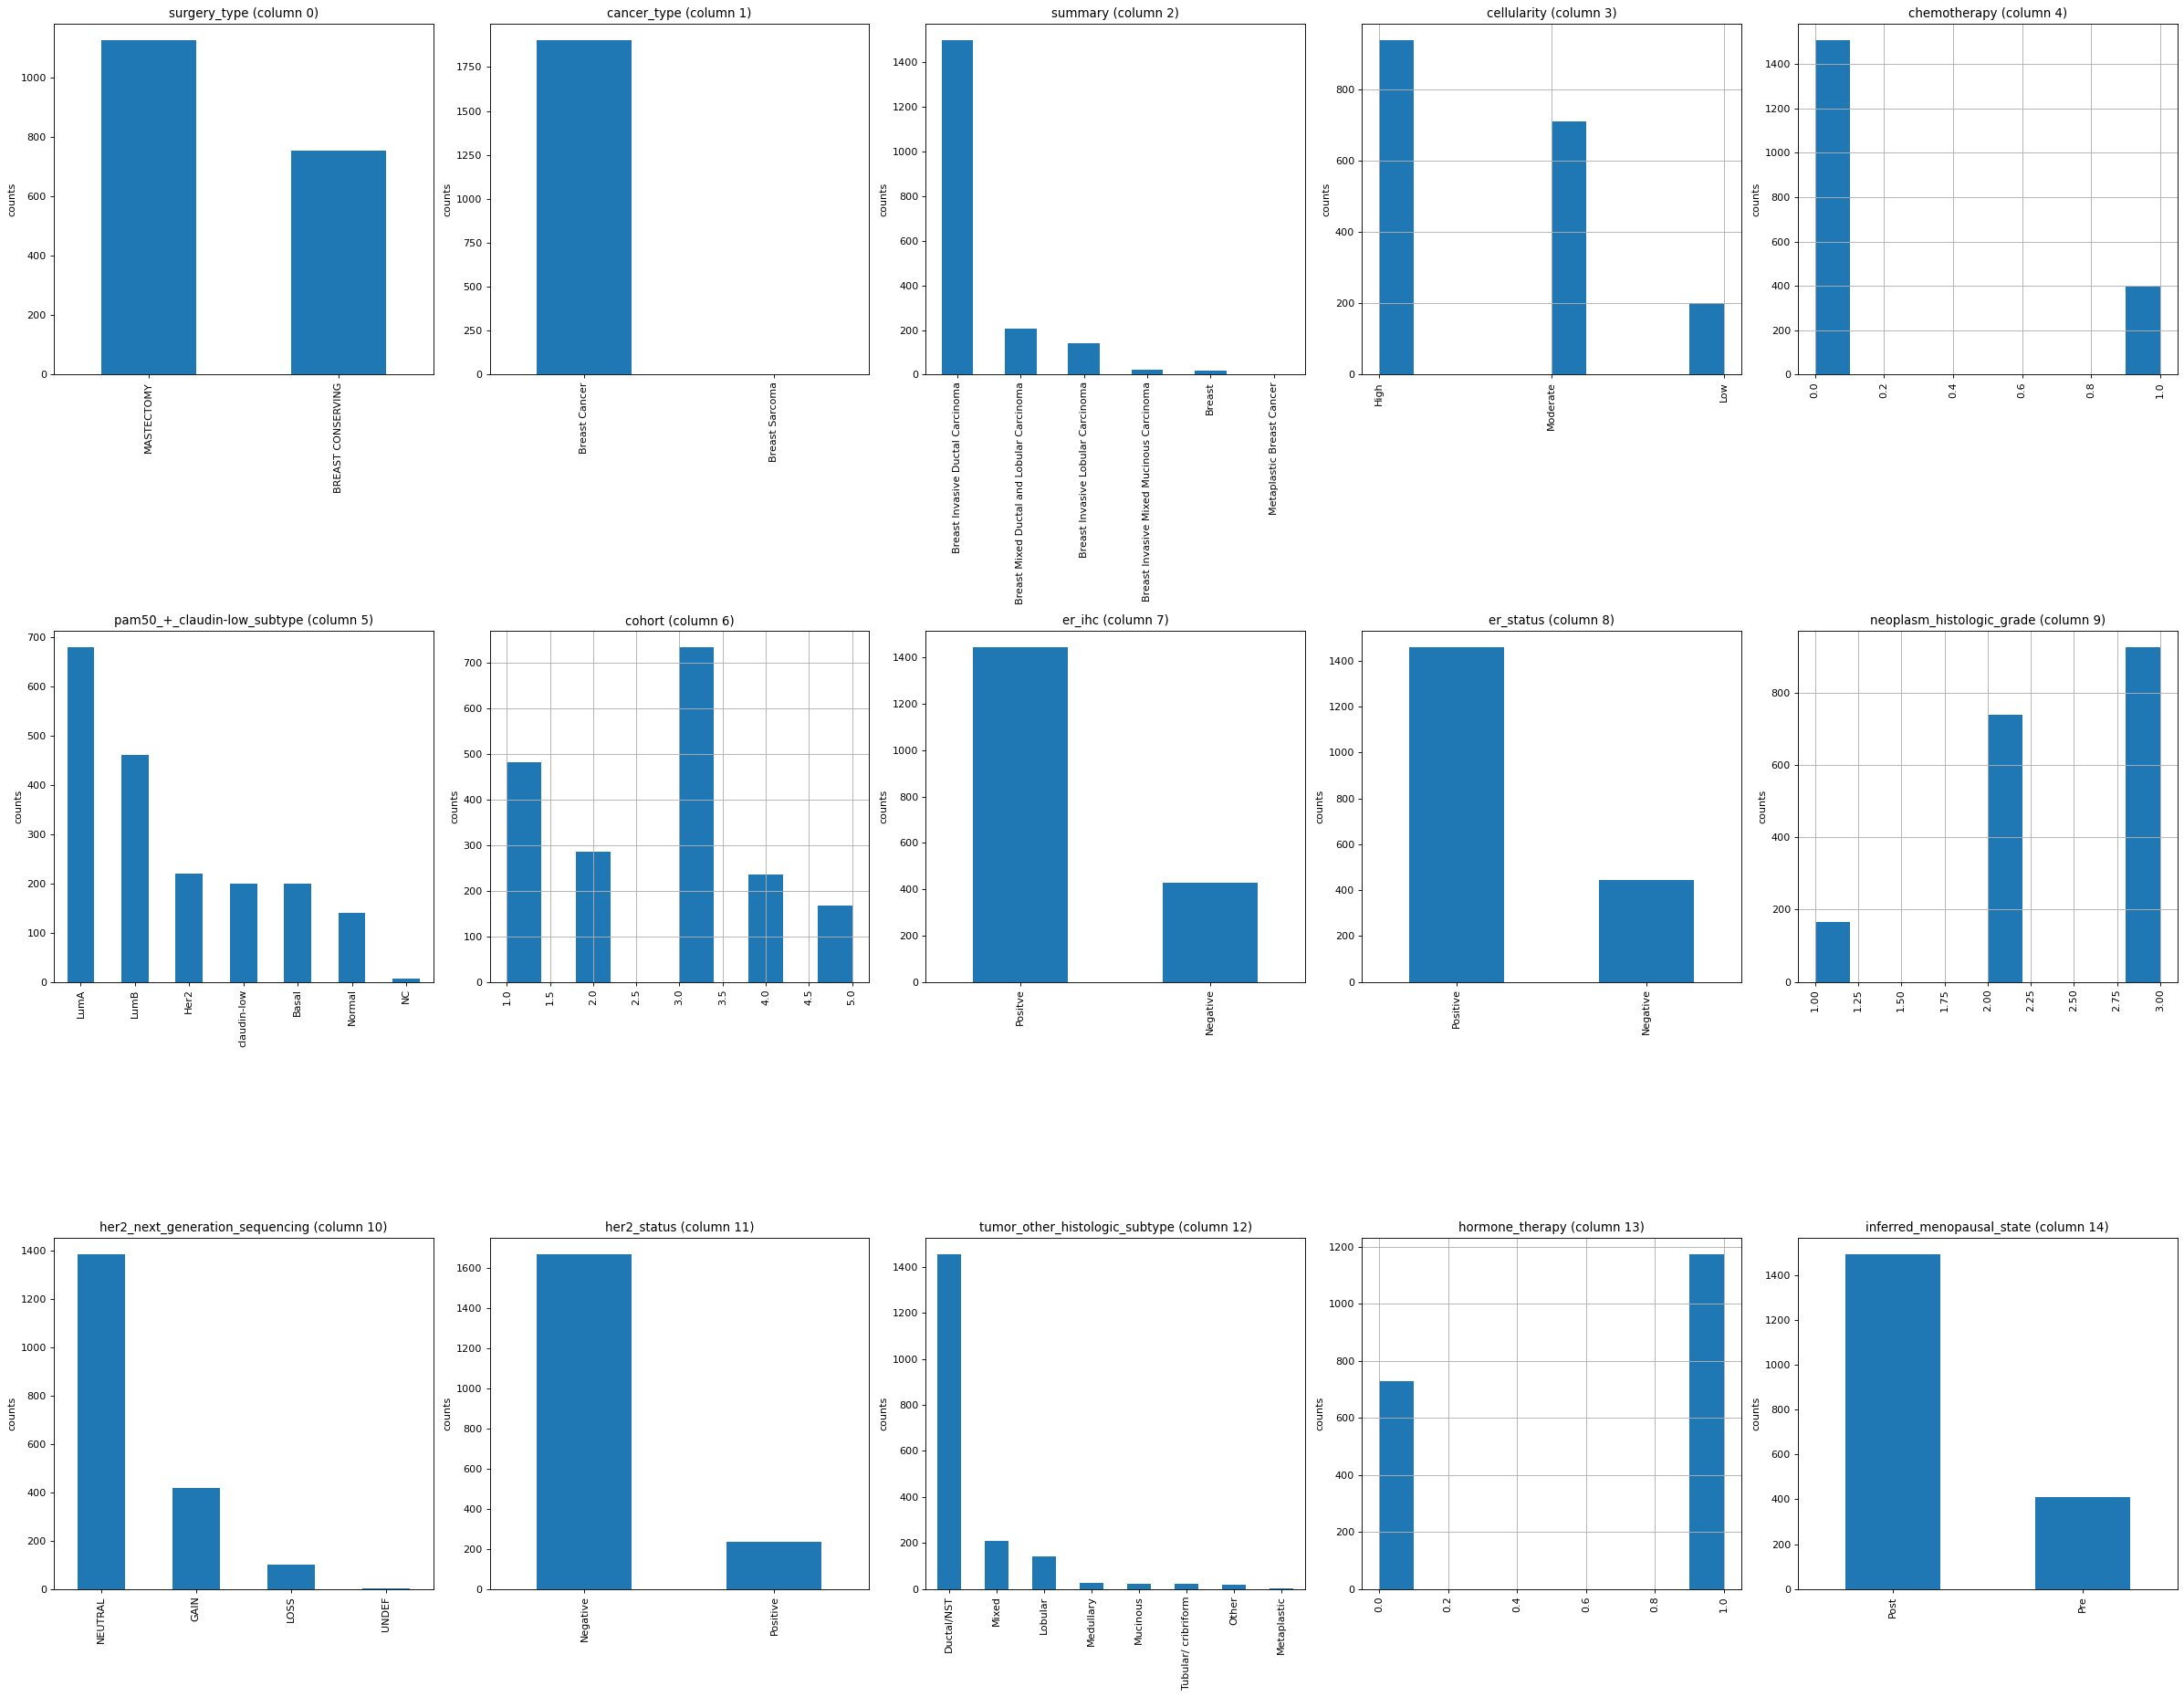

In [13]:
plotPerColumnDistribution(df,15,5)

### **Dropping Unwanted Non-Clinical columns:**

In [14]:
non_clinical_attributes = df.columns[31:]
cdf = df.drop(non_clinical_attributes, axis=1)
cdf.head()

,patient_id,age_at_diagnosis,surgery_type,cancer_type,summary,cellularity,chemotherapy,pam50_+_claudin-low_subtype,cohort,er_ihc,...,nottingham_prognostic_index,oncotree_code,overall_survival_months,overall_survival,pr_status,radio_therapy,3-gene_classifier_subtype,tumor_size,tumor_stage,death_from_cancer
0,0,75.65,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,NaN,0,claudin-low,1.0,Positve,...,6.044,IDC,140.500000,1,Negative,1,ER-/HER2-,22.0,2.0,Living
1,2,43.19,BREAST CONSERVING,Breast Cancer,Breast Invasive Ductal Carcinoma,High,0,LumA,1.0,Positve,...,4.020,IDC,84.633333,1,Positive,1,ER+/HER2- High Prolif,10.0,1.0,Living
2,5,48.87,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,High,1,LumB,1.0,Positve,...,4.030,IDC,163.700000,0,Positive,0,NaN,15.0,2.0,Died of Disease
3,6,47.68,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,Moderate,1,LumB,1.0,Positve,...,4.050,MDLC,164.933333,1,Positive,1,NaN,25.0,2.0,Living
4,8,76.97,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,High,1,LumB,1.0,Positve,...,6.080,MDLC,41.366667,0,Positive,1,ER+/HER2- High Prolif,40.0,2.0,Died of Disease


In [15]:
cdf.shape

(1904, 31)

### **Scaling, Label Encoding , Concatenating dataframes :**

In [16]:
numerical_df =cdf[cdf.select_dtypes(include = np.number).columns.tolist()]
scaler = StandardScaler()
std = scaler.fit_transform(numerical_df)
std_df = pd.DataFrame(std, index = numerical_df.index, columns = numerical_df.columns)
std_df

,patient_id,age_at_diagnosis,chemotherapy,cohort,neoplasm_histologic_grade,hormone_therapy,lymph_nodes_examined_positive,mutation_count,nottingham_prognostic_index,overall_survival_months,overall_survival,radio_therapy,tumor_size,tumor_stage
0,-1.663366,1.122359,-0.512445,-1.338368,0.897956,0.788547,1.960788,NaN,1.757557,0.201518,1.173469,0.821330,-0.279656,0.396748
1,-1.662518,-1.379317,-0.512445,-1.338368,0.897956,0.788547,-0.490841,-0.911280,-0.011378,-0.530544,1.173469,0.821330,-1.071371,-1.193646
2,-1.661245,-0.941562,1.951430,-1.338368,-0.639479,0.788547,-0.245678,-0.911280,-0.002638,0.505525,-0.852174,-1.217538,-0.741490,0.396748
3,-1.660821,-1.033275,1.951430,-1.338368,-0.639479,0.788547,0.244648,-1.157725,0.014841,0.521686,1.173469,0.821330,-0.081727,0.396748
4,-1.659973,1.224091,1.951430,-1.338368,0.897956,0.788547,1.470462,-0.911280,1.789021,-1.097499,-0.852174,0.821330,0.907918,0.396748
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1899,1.430543,-1.386253,-0.512445,1.104047,0.897956,0.788547,-0.245678,-0.418388,0.888821,0.940132,1.173469,0.821330,-0.081727,NaN
1900,1.430967,-1.403208,-0.512445,1.104047,0.897956,-1.268156,-0.245678,0.074504,0.880081,-1.053383,-0.852174,0.821330,-0.411608,NaN
1901,1.431391,0.139723,-0.512445,1.104047,0.897956,0.788547,10.541487,-0.418388,1.762801,0.666264,-0.852174,0.821330,-0.081727,NaN
1902,1.431815,0.005622,-0.512445,1.104047,-0.639479,0.788547,2.451113,2.292516,0.888821,-0.509578,-0.852174,-1.217538,-0.081727,NaN


In [17]:
non_numerical_df =cdf[cdf.select_dtypes(include=object).columns.tolist()]
non_numerical_df

,surgery_type,cancer_type,summary,cellularity,pam50_+_claudin-low_subtype,er_ihc,er_status,her2_next_generation_sequencing,her2_status,tumor_other_histologic_subtype,inferred_menopausal_state,integrative_cluster,primary_tumor_laterality,oncotree_code,pr_status,3-gene_classifier_subtype,death_from_cancer
0,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,NaN,claudin-low,Positve,Positive,NEUTRAL,Negative,Ductal/NST,Post,4ER+,Right,IDC,Negative,ER-/HER2-,Living
1,BREAST CONSERVING,Breast Cancer,Breast Invasive Ductal Carcinoma,High,LumA,Positve,Positive,NEUTRAL,Negative,Ductal/NST,Pre,4ER+,Right,IDC,Positive,ER+/HER2- High Prolif,Living
2,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,High,LumB,Positve,Positive,NEUTRAL,Negative,Ductal/NST,Pre,3,Right,IDC,Positive,NaN,Died of Disease
3,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,Moderate,LumB,Positve,Positive,NEUTRAL,Negative,Mixed,Pre,9,Right,MDLC,Positive,NaN,Living
4,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,High,LumB,Positve,Positive,NEUTRAL,Negative,Mixed,Post,9,Right,MDLC,Positive,ER+/HER2- High Prolif,Died of Disease
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1899,BREAST CONSERVING,Breast Cancer,Breast Invasive Lobular Carcinoma,High,LumA,Positve,Positive,NEUTRAL,Negative,Lobular,Pre,3,Right,ILC,Positive,ER+/HER2- Low Prolif,Living
1900,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,High,LumB,Positve,Positive,GAIN,Positive,Ductal/NST,Pre,5,NaN,IDC,Negative,NaN,Died of Disease
1901,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,High,LumB,Positve,Positive,NEUTRAL,Negative,Ductal/NST,Post,1,Left,IDC,Positive,NaN,Died of Disease
1902,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,Moderate,LumB,Positve,Positive,NEUTRAL,Negative,Ductal/NST,Post,1,NaN,IDC,Positive,ER+/HER2- High Prolif,Died of Other Causes


In [18]:
le = preprocessing.LabelEncoder()
cols=['er_ihc', 'pr_status', 'cellularity','er_status','her2_next_generation_sequencing','her2_status','primary_tumor_laterality', 'surgery_type', 'summary', 'tumor_other_histologic_subtype', 'death_from_cancer','oncotree_code','inferred_menopausal_state','pam50_+_claudin-low_subtype','cancer_type','3-gene_classifier_subtype','integrative_cluster']
for i in cols:
  non_numerical_df[i]=le.fit_transform(non_numerical_df[i].astype(str))
non_numerical_df.head()

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,surgery_type,cancer_type,summary,cellularity,pam50_+_claudin-low_subtype,er_ihc,er_status,her2_next_generation_sequencing,her2_status,tumor_other_histologic_subtype,inferred_menopausal_state,integrative_cluster,primary_tumor_laterality,oncotree_code,pr_status,3-gene_classifier_subtype,death_from_cancer
0,1,0,1,3,6,1,1,2,0,0,0,4,1,1,0,2,2
1,0,0,1,0,2,1,1,2,0,0,1,4,1,1,1,0,2
2,1,0,1,0,3,1,1,2,0,0,1,3,1,1,1,4,0
3,1,0,4,2,3,1,1,2,0,4,1,10,1,5,1,4,2
4,1,0,4,0,3,1,1,2,0,4,0,10,1,5,1,0,0


In [19]:
cldf=pd.concat([numerical_df,non_numerical_df],axis=1)
cldf.sample(5)

,patient_id,age_at_diagnosis,chemotherapy,cohort,neoplasm_histologic_grade,hormone_therapy,lymph_nodes_examined_positive,mutation_count,nottingham_prognostic_index,overall_survival_months,...,her2_next_generation_sequencing,her2_status,tumor_other_histologic_subtype,inferred_menopausal_state,integrative_cluster,primary_tumor_laterality,oncotree_code,pr_status,3-gene_classifier_subtype,death_from_cancer
1088,4991,77.13,0,3.0,3.0,1,1.0,4.0,5.0800,126.866667,...,0,0,0,0,7,1,1,0,0,2
1508,6014,44.48,0,5.0,1.0,0,0.0,2.0,2.1140,191.933333,...,2,0,1,1,5,1,2,1,1,1
1839,7212,62.26,0,4.0,3.0,1,0.0,3.0,4.0286,52.500000,...,0,0,1,0,3,2,2,1,1,1
846,4354,55.01,0,3.0,2.0,1,2.0,2.0,4.0700,15.366667,...,2,0,0,0,0,0,1,0,4,0
7,22,89.08,0,1.0,2.0,1,1.0,1.0,4.0580,99.533333,...,2,0,4,0,3,0,5,0,4,1


In [20]:
cldf.describe()

,patient_id,age_at_diagnosis,chemotherapy,cohort,neoplasm_histologic_grade,hormone_therapy,lymph_nodes_examined_positive,mutation_count,nottingham_prognostic_index,overall_survival_months,...,her2_next_generation_sequencing,her2_status,tumor_other_histologic_subtype,inferred_menopausal_state,integrative_cluster,primary_tumor_laterality,oncotree_code,pr_status,3-gene_classifier_subtype,death_from_cancer
count,1904.000000,1904.000000,1904.000000,1904.000000,1832.000000,1904.000000,1904.000000,1859.000000,1904.000000,1904.000000,...,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000
mean,3921.982143,61.087054,0.207983,2.643908,2.415939,0.616597,2.002101,5.697687,4.033019,125.121324,...,1.511555,0.123950,0.788866,0.215861,5.107143,0.564601,1.564601,0.529937,1.354517,1.095063
std,2358.478332,12.978711,0.405971,1.228615,0.650612,0.486343,4.079993,4.058778,1.144492,76.334148,...,0.832140,0.329611,1.704546,0.411527,3.170919,0.597795,1.324028,0.499234,1.305170,0.860713
min,0.000000,21.930000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,896.500000,51.375000,0.000000,1.000000,2.000000,0.000000,0.000000,3.000000,3.046000,60.825000,...,1.000000,0.000000,0.000000,0.000000,3.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,4730.500000,61.770000,0.000000,3.000000,3.000000,1.000000,0.000000,5.000000,4.042000,115.616667,...,2.000000,0.000000,0.000000,0.000000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000
75%,5536.250000,70.592500,0.000000,3.000000,3.000000,1.000000,2.000000,7.000000,5.040250,184.716667,...,2.000000,0.000000,0.000000,0.000000,8.000000,1.000000,1.000000,1.000000,2.000000,2.000000
max,7299.000000,96.290000,1.000000,5.000000,3.000000,1.000000,45.000000,80.000000,6.360000,355.200000,...,3.000000,1.000000,8.000000,1.000000,10.000000,2.000000,6.000000,1.000000,4.000000,3.000000


### **Dealing with Nan Values:**

In [21]:
count=cldf.isna().sum().sort_values(ascending = False)
percent=(cldf.isna().sum()/len(cldf.columns))
na_val=pd.concat([count, percent], axis = 1, keys = ['NaN_in_each_column', 'Percent_Nan_in_each_column'])
na_val.head(15)

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


,NaN_in_each_column,Percent_Nan_in_each_column
3-gene_classifier_subtype,0,0.0
age_at_diagnosis,0,0.0
cancer_type,0,0.0
cellularity,0,0.0
chemotherapy,0,0.0
cohort,0,0.0
death_from_cancer,0,0.0
er_ihc,0,0.0
er_status,0,0.0
her2_next_generation_sequencing,0,0.0


In [22]:
cldf.drop('tumor_stage',axis=1,inplace=True)
cldf.dropna(subset=['neoplasm_histologic_grade', 'mutation_count','tumor_size'],inplace=True)

In [23]:
cldf.isna().sum().sum()

0

### **Higest Correlation with Survival/Death:**

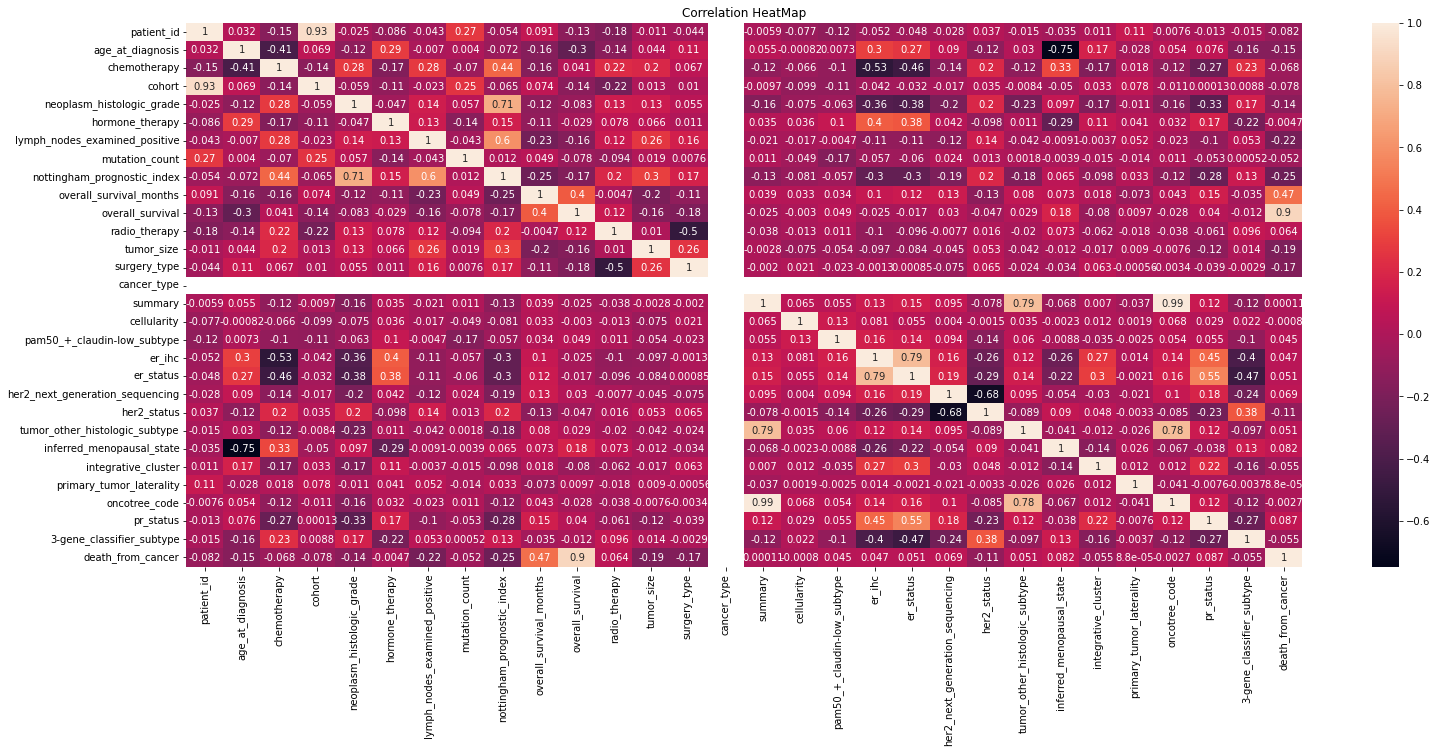

In [24]:
fig, ax = plt.subplots( figsize = (25, 10))
sns.heatmap(cldf.corr(),annot=True)
ax.set_title('Correlation HeatMap')
plt.show();

In [25]:
corr = pd.pivot_table(cldf, columns=['overall_survival'])
bestDeathCorr = corr.iloc[:,0].sort_values(ascending=False).head(30)
bestDeathCorr

patient_id                         4239.118908
overall_survival_months              98.967901
age_at_diagnosis                     64.240975
tumor_size                           28.425429
mutation_count                        5.909357
integrative_cluster                   5.288499
nottingham_prognostic_index           4.274200
cohort                                2.808967
lymph_nodes_examined_positive         2.562378
neoplasm_histologic_grade             2.466862
pam50_+_claudin-low_subtype           2.438596
oncotree_code                         1.585770
her2_next_generation_sequencing       1.489279
summary                               1.468811
3-gene_classifier_subtype             1.365497
cellularity                           0.906433
er_ihc                                0.789474
er_status                             0.769006
tumor_other_histologic_subtype        0.727096
surgery_type                          0.687135
hormone_therapy                       0.625731
primary_tumor

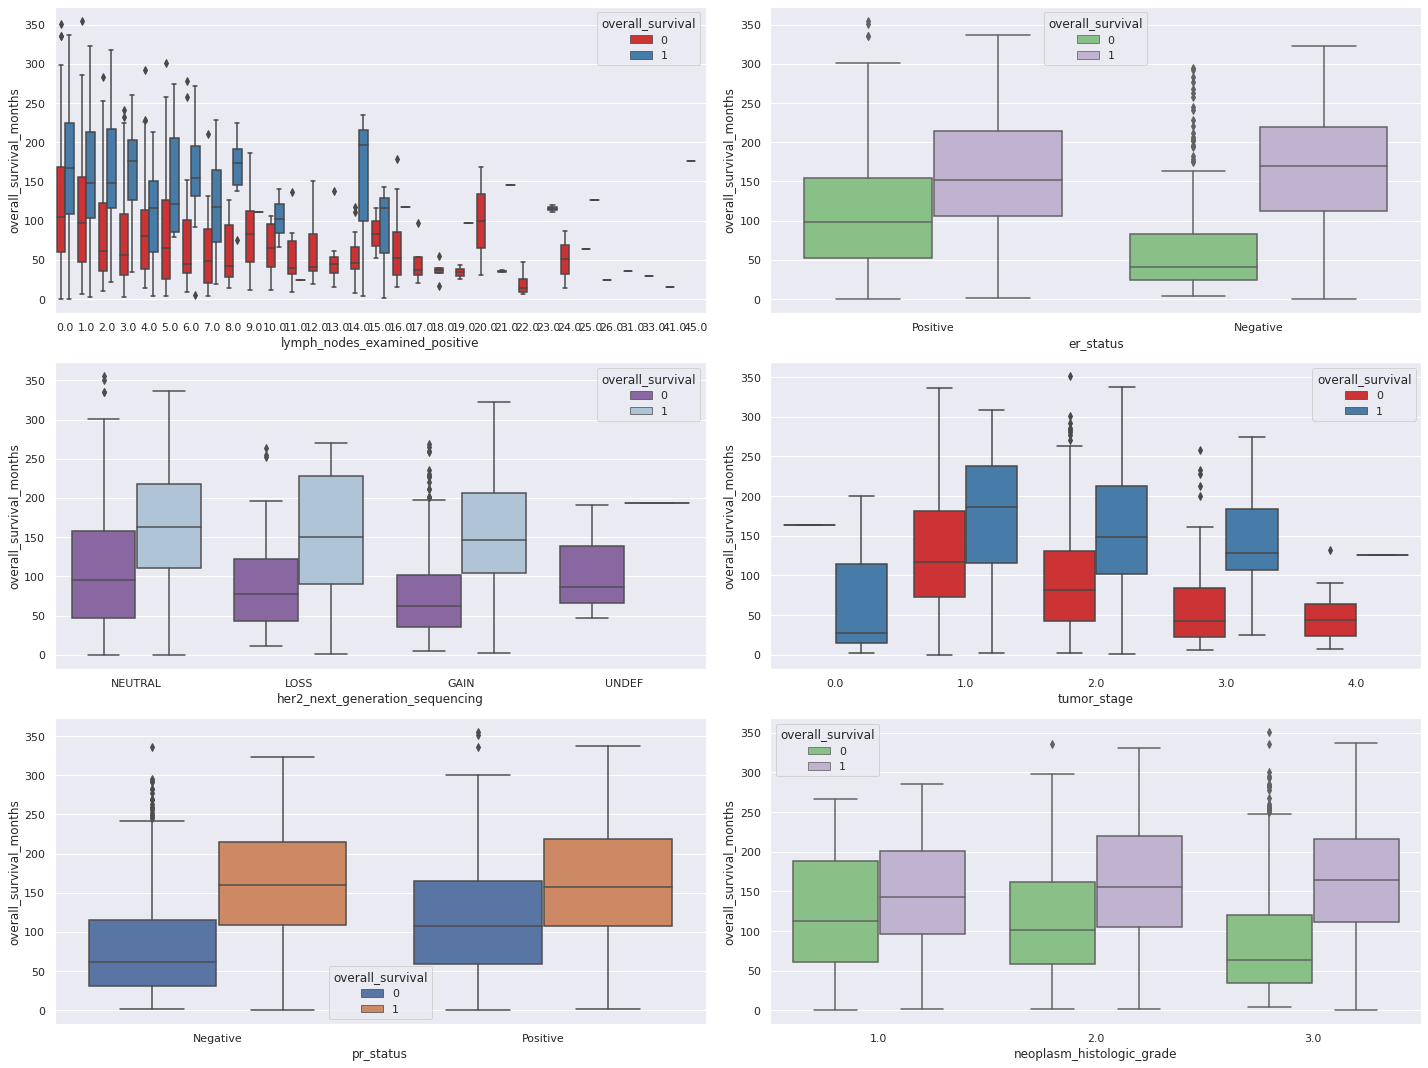

In [26]:
sns.set(style="darkgrid")
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20,15))
sns.boxplot(x='lymph_nodes_examined_positive', y='overall_survival_months', hue='overall_survival', data=df,ax=axes[0, 0],palette="Set1") 
sns.boxplot(x='er_status', y='overall_survival_months', hue='overall_survival', data=df, ax=axes[0, 1],palette="Accent")
sns.boxplot(x='her2_next_generation_sequencing', y='overall_survival_months', hue='overall_survival', data=df, ax=axes[1, 0],palette="BuPu_r")
sns.boxplot(x='tumor_stage', y='overall_survival_months', hue='overall_survival', data=df, ax=axes[1, 1],palette="Set1")
sns.boxplot(x='pr_status', y='overall_survival_months', hue='overall_survival', data=df, ax=axes[2, 0])
sns.boxplot(x='neoplasm_histologic_grade', y='overall_survival_months', hue='overall_survival', data=df, ax=axes[2, 1],palette="Accent")
plt.tight_layout()
plt.savefig("")

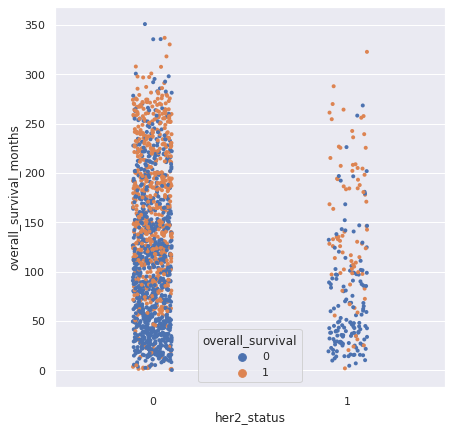

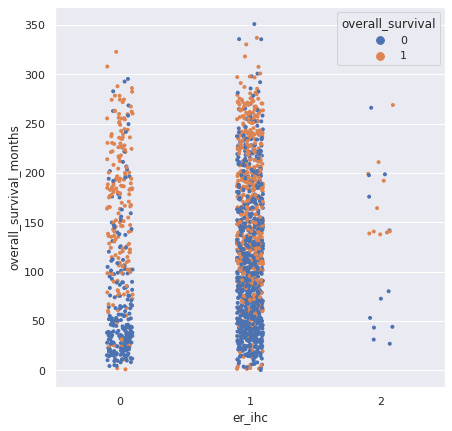

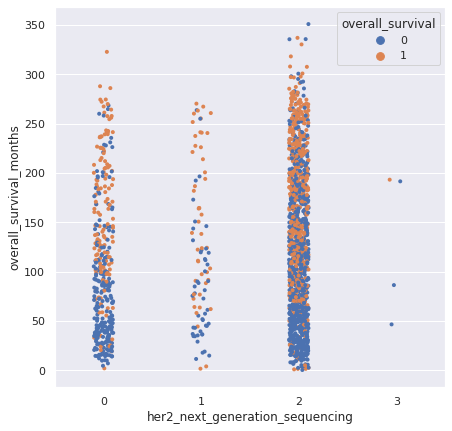

In [27]:
plt.figure(figsize=(7,7))
sns.stripplot(x= "her2_status", y = "overall_survival_months", hue='overall_survival', size=4, data =cldf)
plt.show()
plt.figure(figsize=(7,7))
sns.stripplot(x= "er_ihc", y = "overall_survival_months", hue='overall_survival', size=4, data =cldf)
plt.show()
plt.figure(figsize=(7,7))
sns.stripplot(x= "her2_next_generation_sequencing", y = "overall_survival_months", hue='overall_survival', size=4, data =cldf)
plt.show()

In [28]:
print('Average age of all patients: ', cldf['age_at_diagnosis'].mean())
print('Most frequent type of surgerys: ',cldf['surgery_type'].mode())
print('Predominant breast cancer sub-class in dataset:',cldf['summary'].mode())
print('Most frequent tumor subtype:',cldf['tumor_other_histologic_subtype'].mode())
print('Average survival duration:', int(cldf["overall_survival_months"].mean()), 'months')

Average age of all patients:  60.916694915254205
Most frequent type of surgerys:  0    1
dtype: int64
Predominant breast cancer sub-class in dataset: 0    1
dtype: int64
Most frequent tumor subtype: 0    0
dtype: int64
Average survival duration: 124 months


### **Splitting data for Training and Testing:**

In [29]:
Y=cldf['overall_survival_months']

In [30]:
X=cldf
X.drop(labels=['overall_survival_months'],axis=1,inplace=True)
X.drop(labels=['cancer_type'],axis=1,inplace=True)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, random_state=42)

### **Principal Componenet Analysis::**

In [31]:
pca_2 = PCA(n_components=2)
pca_2_result = pca_2.fit_transform(X)
print('Explained variation per principal component: {}'.format(pca_2.explained_variance_ratio_))
print('Cumulative variance explained by 2 principal components: {:.2%}'.format(np.sum(pca_2.explained_variance_ratio_)))

Explained variation per principal component: [9.99915504e-01 4.35507714e-05]
Cumulative variance explained by 2 principal components: 100.00%


### **Model Building**

### Finding optimum value of K:

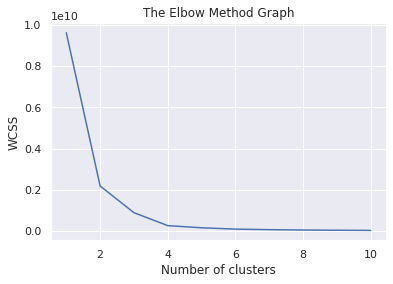

In [32]:
wcss=[]
for i in range(1,11): 
  kmeans = KMeans(n_clusters=i, init ='k-means++', max_iter=300,  n_init=10,random_state=0 )
  kmeans.fit(X)
  wcss.append(kmeans.inertia_)
plt.plot(range(1,11),wcss)
plt.title('The Elbow Method Graph')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

Parameter: {'n_clusters': 2} Score 0.6809773099581606
Parameter: {'n_clusters': 3} Score 0.625279840158441
Parameter: {'n_clusters': 4} Score 0.7351700702209414
Parameter: {'n_clusters': 5} Score 0.697040994313478
Parameter: {'n_clusters': 10} Score 0.6469944606449299
Parameter: {'n_clusters': 15} Score 0.6194899733080482
Parameter: {'n_clusters': 20} Score 0.5493775414209058
Parameter: {'n_clusters': 25} Score 0.5148012067712652
Parameter: {'n_clusters': 30} Score 0.4945953349372418
Parameter: {'n_clusters': 35} Score 0.4784974282965801
Parameter: {'n_clusters': 40} Score 0.46192034713225044


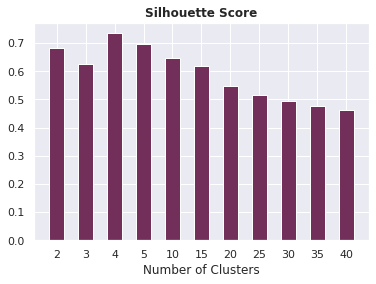

In [33]:
parameters = [2, 3, 4, 5, 10, 15, 20, 25, 30, 35, 40]
parameter_grid = ParameterGrid({'n_clusters': parameters})
best_score = -1
kmeans_model = KMeans()     # instantiating KMeans model
silhouette_scores = []
# evaluation based on silhouette_score
for p in parameter_grid:
    kmeans_model.set_params(**p)    # set current hyper parameter
    kmeans_model.fit(X_train)          # fit model on wine dataset, this will find clusters based on parameter p
    ss = metrics.silhouette_score(X_train, kmeans_model.labels_)   # calculate silhouette_score
    silhouette_scores += [ss]       # store all the scores
    print('Parameter:', p, 'Score', ss)
    # check p which has the best score
    if ss > best_score:
        best_score = ss
        best_grid = p
# plotting silhouette score
plt.bar(range(len(silhouette_scores)), list(silhouette_scores), align='center', color='#722f59', width=0.5)
plt.xticks(range(len(silhouette_scores)), list(parameters))
plt.title('Silhouette Score', fontweight='bold')
plt.xlabel('Number of Clusters')
plt.show()

In [34]:
kmeanstrain = KMeans(n_clusters=4)
kmeanstrain.fit(X_train)
centroids = kmeanstrain.cluster_centers_
centroids_pca = pca_2.transform(centroids)
y_kmeans = kmeanstrain.predict(X_train)

cluster_map = pd.DataFrame()
cluster_map['data_index'] = X_train.index.values
cluster_map['cluster'] = kmeanstrain.labels_
X_train["Cluster"] = y_kmeans

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [35]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
centroids = kmeans.cluster_centers_
centroids_pca = pca_2.transform(centroids)
y_kmeans = kmeans.predict(X)

cluster_map = pd.DataFrame()
cluster_map['data_index'] = X.index.values
cluster_map['cluster'] = kmeans.labels_
X["Cluster"] = y_kmeans

In [36]:
def visualizing_results(pca_result, label, centroids_pca):

    x = pca_result[:, 0]
    y = pca_result[:, 1]
    sns.set(style="darkgrid")
    plt.scatter(x, y, c=label, alpha=0.5, s= 200, cmap="Accent")  # plot different colors per cluster
    plt.title('Survival period clusters')
    plt.gcf().set_size_inches((20, 20))
    plt.xlabel('PCA 1')
    plt.ylabel('PCA 2')

    plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], marker='X', s=200, linewidths=1.5,
                color='red', edgecolors="black", lw=1.5)

    plt.show()

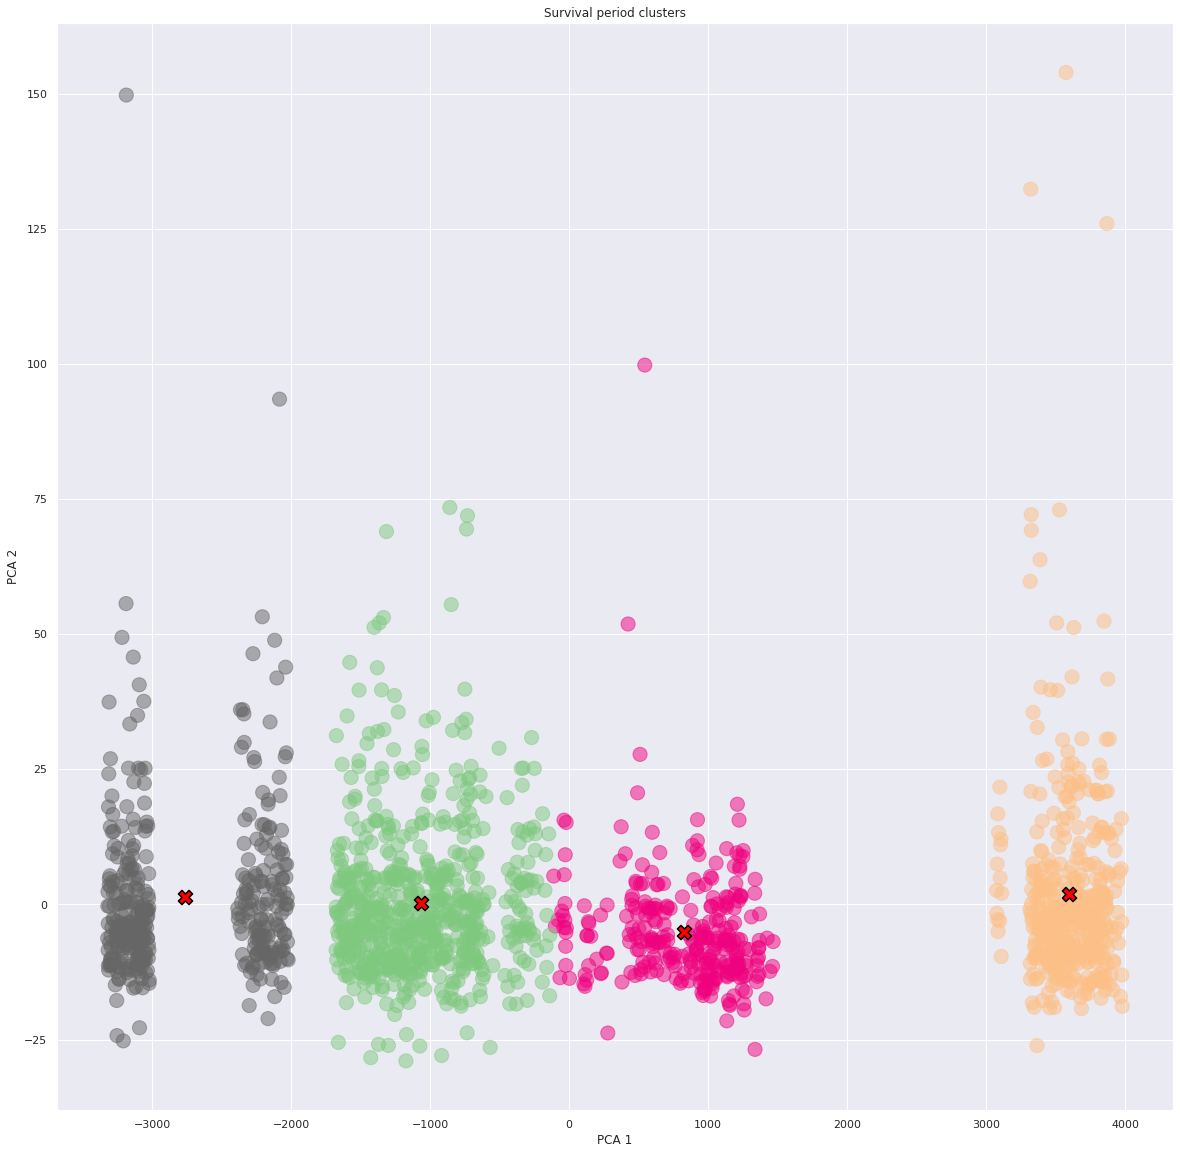

In [37]:
visualizing_results(pca_2_result, kmeans.labels_, centroids_pca)

## **Survival Analysis:**

In [38]:
X_train["pr_status"].value_counts()

1    655
0    584
Name: pr_status, dtype: int64

In [39]:
X_train["Cluster"].value_counts()

2    459
0    300
1    274
3    206
Name: Cluster, dtype: int64

In [40]:
X_train.shape

(1239, 29)

In [ ]:
!pip install scikit-survival

In [ ]:
!pip install scikit-learn==0.24.0

In [ ]:
!pip install delayed

In [27]:
from sksurv.nonparametric import kaplan_meier_estimator

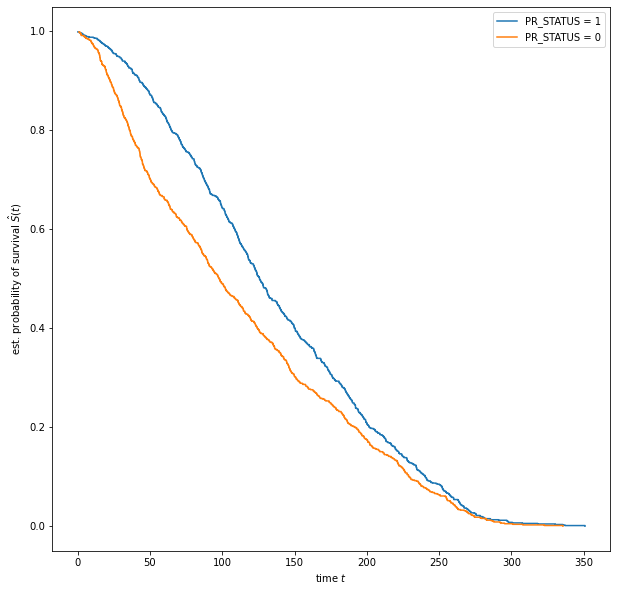

In [39]:
for pr_status in (1, 0):
    mask_treat = X["pr_status"] == pr_status
    time_treatment, survival_prob_treatment = kaplan_meier_estimator(Y.astype('bool')[mask_treat], Y[mask_treat])

    plt.step(time_treatment, survival_prob_treatment, where="post",
             label="PR_STATUS = %s" % pr_status)
plt.gcf().set_size_inches((10, 10))
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="best")

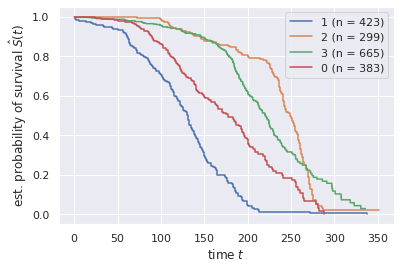

In [28]:
for value in X['Cluster'].unique():
    mask = X['Cluster'] == value
    time_cell, survival_prob_cell = kaplan_meier_estimator(X["overall_survival"].astype('bool')[mask],Y[mask])
    plt.step(time_cell, survival_prob_cell, where="post",
             label="%s (n = %d)" % (value, mask.sum()))

plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="best")

## **Intepretting Clusters:**

In [29]:
pd.crosstab(Y,X_train['Cluster'])

Cluster,0,1,2,3
overall_survival_months,,,,
0.100000,0,0,1,0
1.433333,0,1,0,0
1.766667,0,1,0,0
2.300000,0,0,1,0
2.400000,0,1,0,0
...,...,...,...,...
322.833333,1,0,0,0
330.366667,1,0,0,0
335.600000,1,0,0,0


In [30]:
pd.crosstab(X_train['overall_survival'],X_train['Cluster'], values=Y, aggfunc=np.average)

Cluster,0,1,2,3
overall_survival,,,,
0,107.386583,71.481022,90.166667,112.629487
1,187.793617,115.052352,143.692157,221.195752


****

In [32]:
pd.crosstab(X_train['overall_survival'],X_train['Cluster'], values=X_train['tumor_size'], aggfunc=np.average)

Cluster,0,1,2,3
overall_survival,,,,
0,27.317610,32.569343,28.564452,24.173077
1,23.411348,24.441718,25.587983,20.328431


In [33]:
pd.crosstab(X_train['overall_survival'],X_train['Cluster'], values=df['integrative_cluster'],aggfunc=pd.Series.mode)

Cluster,0,1,2,3
overall_survival,,,,
0,8,8,8,5
1,10,3,8,"[10, 3]"


In [34]:
pd.crosstab(X_train['overall_survival'],X_train['Cluster'], values=df['death_from_cancer'],aggfunc=pd.Series.mode)

Cluster,0,1,2,3
overall_survival,,,,
0,Died of Disease,Died of Disease,Died of Other Causes,Died of Disease
1,Living,Living,Living,Living


In [35]:
pd.crosstab(X_train['overall_survival'],X_train['Cluster'], values=df['pam50_+_claudin-low_subtype'],aggfunc=pd.Series.mode)

Cluster,0,1,2,3
overall_survival,,,,
0,LumA,LumB,LumB,LumA
1,LumA,LumA,LumA,LumA


In [36]:
pd.crosstab(X_train['overall_survival'],X_train['Cluster'], values=df['3-gene_classifier_subtype'],aggfunc=pd.Series.mode)

Cluster,0,1,2,3
overall_survival,,,,
0,ER+/HER2- High Prolif,ER+/HER2- High Prolif,ER+/HER2- High Prolif,ER+/HER2- High Prolif
1,ER+/HER2- Low Prolif,ER+/HER2- Low Prolif,ER+/HER2- Low Prolif,ER+/HER2- Low Prolif


In [37]:
pd.crosstab(X_train['overall_survival'],X_train['Cluster'], values=df['tumor_other_histologic_subtype'],aggfunc=pd.Series.mode)

Cluster,0,1,2,3
overall_survival,,,,
0,Ductal/NST,Ductal/NST,Ductal/NST,Ductal/NST
1,Ductal/NST,Ductal/NST,Ductal/NST,Ductal/NST


In [38]:
pd.crosstab(X_train['overall_survival'],X_train['Cluster'], values=df['her2_status'],aggfunc=pd.Series.mode)

Cluster,0,1,2,3
overall_survival,,,,
0,Negative,Negative,Negative,Negative
1,Negative,Negative,Negative,Negative


In [39]:
pd.crosstab(X_train['overall_survival'],X_train['Cluster'], values=df['er_status'],aggfunc=pd.Series.mode)

Cluster,0,1,2,3
overall_survival,,,,
0,Positive,Positive,Positive,Positive
1,Positive,Positive,Positive,Positive


In [40]:
pd.crosstab(X_train['overall_survival'],X_train['Cluster'], values=df['er_ihc'],aggfunc=pd.Series.mode)

Cluster,0,1,2,3
overall_survival,,,,
0,Positve,Positve,Positve,Positve
1,Positve,Positve,Positve,Positve


In [41]:
pd.crosstab(X_train['overall_survival'],X_train['Cluster'], values=df['age_at_diagnosis'],aggfunc=np.mean)

Cluster,0,1,2,3
overall_survival,,,,
0,64.039214,68.855620,66.186710,56.734038
1,55.591986,57.122883,58.019244,53.313529


In [42]:
pd.crosstab(X_train['overall_survival'],X_train['Cluster'], values=df['mutation_count'],aggfunc=np.mean)

Cluster,0,1,2,3
overall_survival,,,,
0,6.688679,4.080292,6.025806,6.048077
1,6.283688,3.282209,6.798319,5.549020


### **Inferences on the Analysis:**

- #### In the average overall survival for the clusters, **cluster 0** has the _highest_ survival rate and **cluster 2 **has the _lowest_ rate.
- ####  
- #### In the average survival for tumor size, _cluster 2_ has the highest survival rate but the death rate is higher than its survival. So we are trying to find the cause of death. We find the mode for the cause of death. From that we infer that the cluster 2 deaths are caused from other causes but not cancer.
- #### 
- #### The average survival for 3-gene_classifier_subtype, for people with _ER+/HER2 Low Prolif_ subtype survival rate is _higher_
- #### 
- #### The average survival for 3-gene_classifier_subtype, for people with _ER+/HER2 High Prolif_ subtype survival rate is _lower_
- #### 
- #### For tumor_other_histologic_subtype overall survival is _highest_  if the subtype is _Ductal/NST_
- #### 
- #### _Elderly_ people tend to have _lower survival_ _no matter_ what is the _stage_ of the cancer
- #### 
- #### For people with _less mutation count_, survival rate is _higher_.

### **Kalplan-Meier Survival Curves:**

0 0


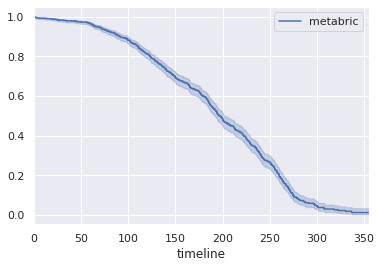

In [43]:
print( df['overall_survival_months'].isna().sum(), df['overall_survival'].isna().sum() )
T = df['overall_survival_months'] 
E = df['overall_survival']
kmf = KaplanMeierFitter(label="metabric")
kmf.fit(T,E)
kmf.plot()

In [44]:
f = 'pam50_+_claudin-low_subtype'
print( df[f].unique() )
df[f].value_counts()

['claudin-low' 'LumA' 'LumB' 'Her2' 'Normal' 'Basal' 'NC']


LumA           679
LumB           461
Her2           220
claudin-low    199
Basal          199
Normal         140
NC               6
Name: pam50_+_claudin-low_subtype, dtype: int64

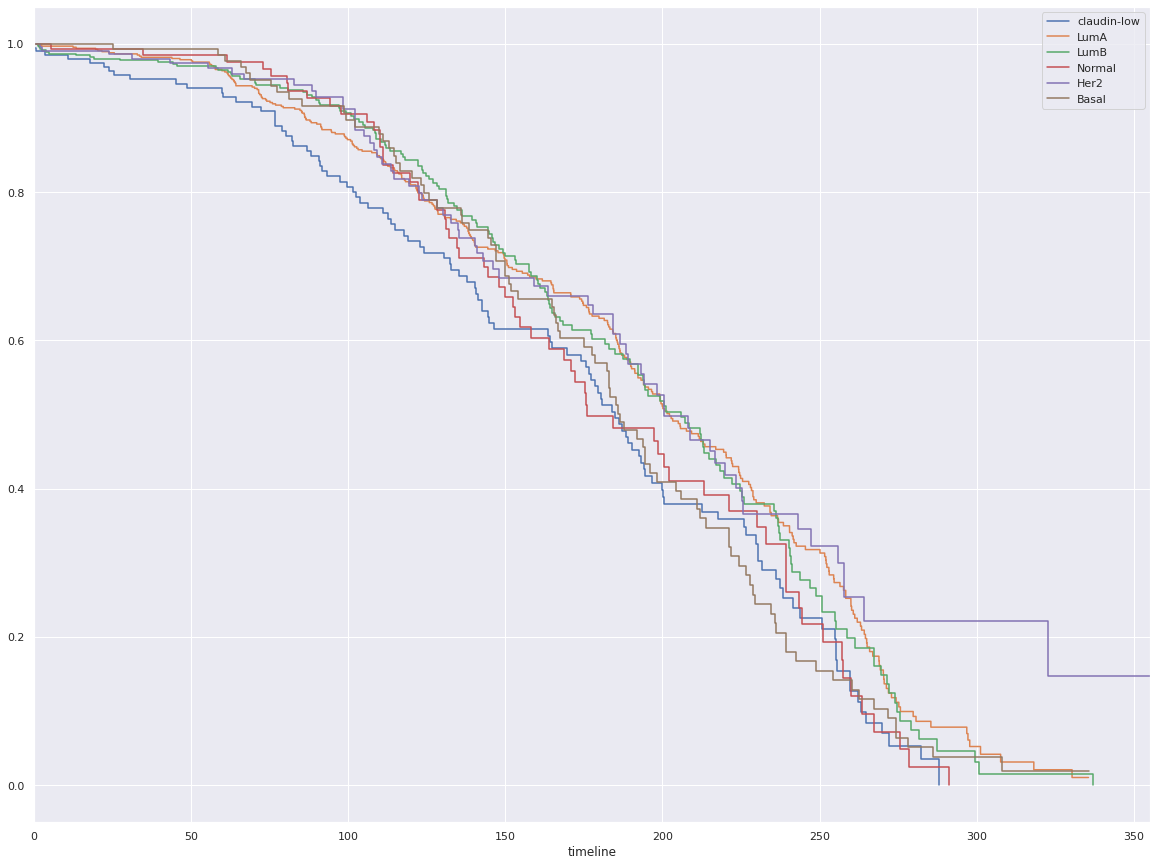

In [45]:
plt.figure(figsize = (20,15))
for v in ['claudin-low', 'LumA', 'LumB', 'Normal', 'Her2', 'Basal']:
    m = df[f] == v
    T = df['overall_survival_months'][m] 
    E = df['overall_survival'][m]
    kmf = KaplanMeierFitter(label=v)
    kmf.fit(T,E)
    kmf.plot(ci_show=False)

- #### During the Initial stage, _claudin-low_ is having the _lowest survival_ rate and the _highest survival_ rate is for _LumB_


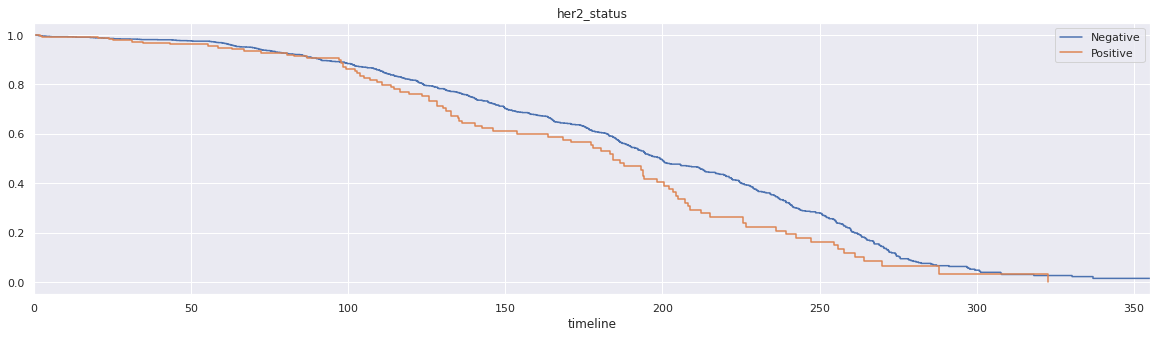

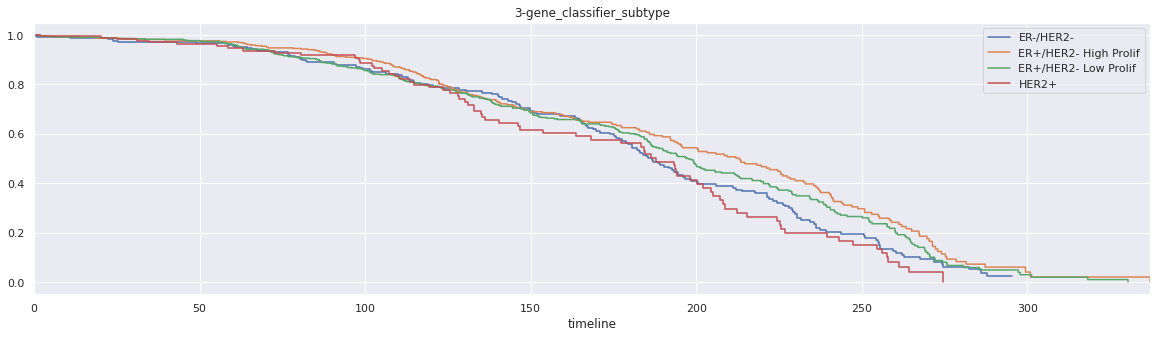

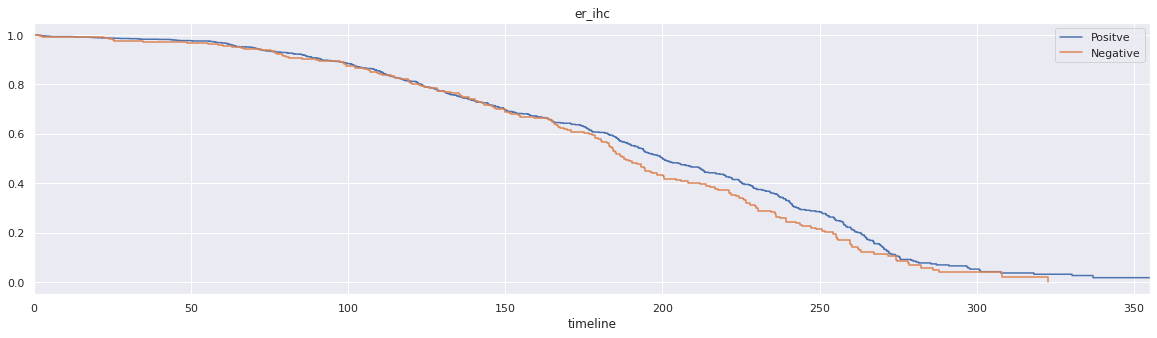

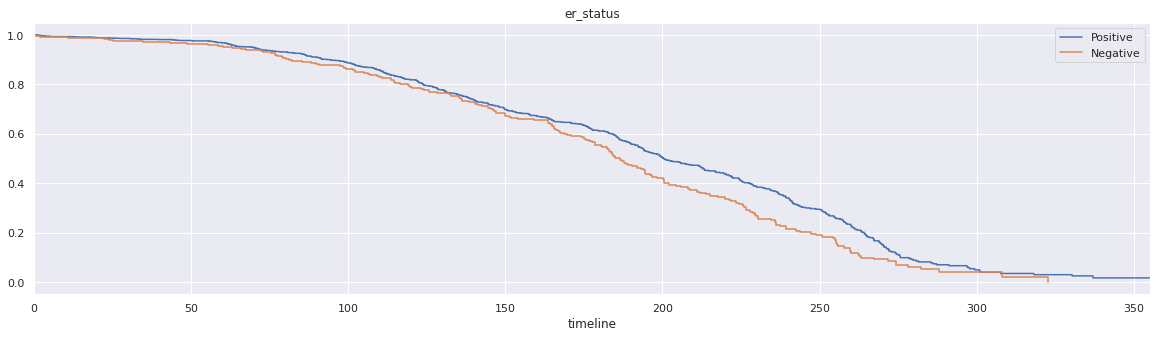

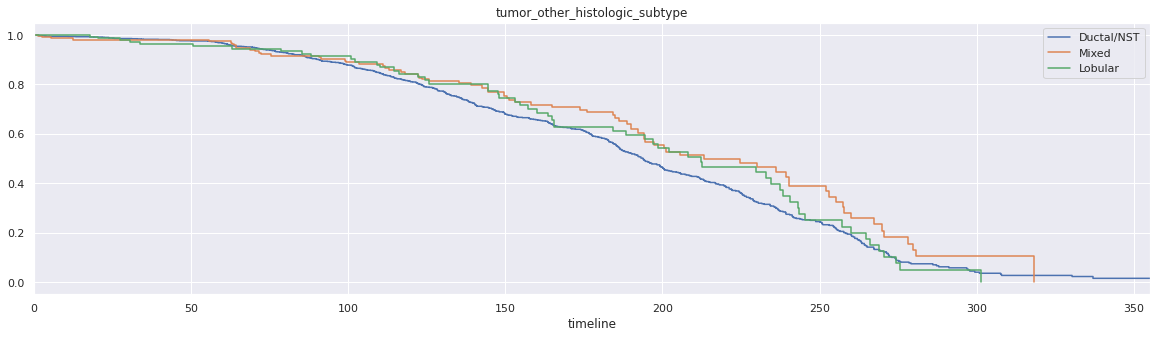

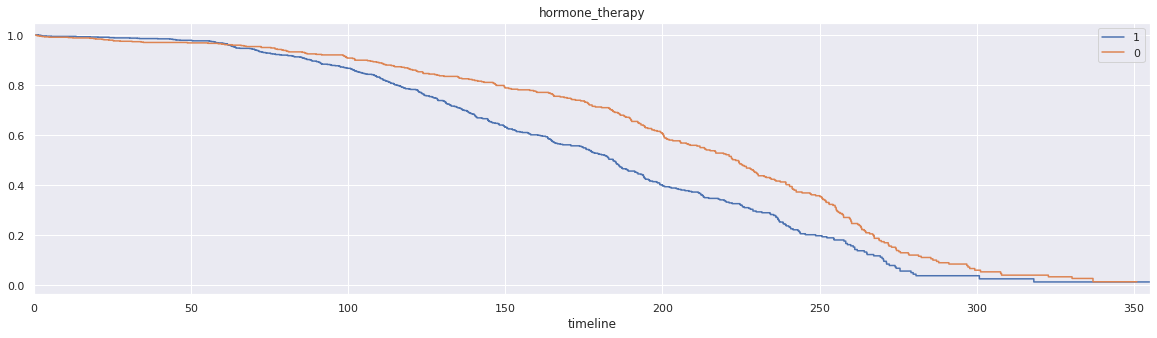

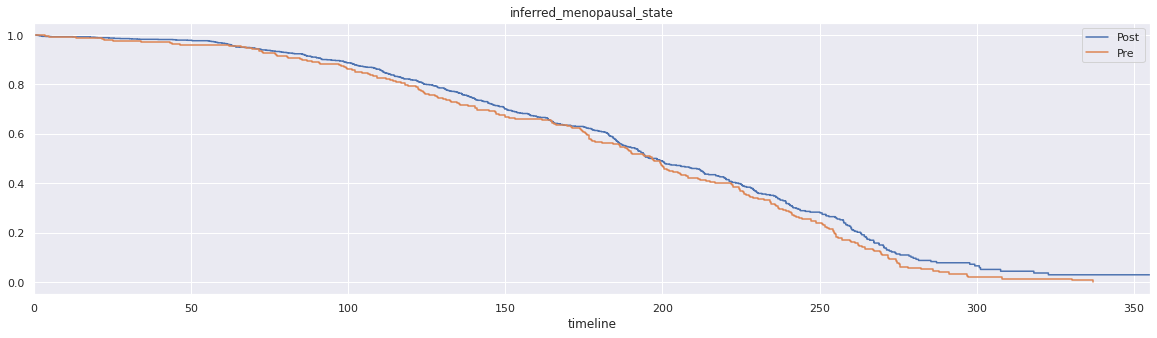

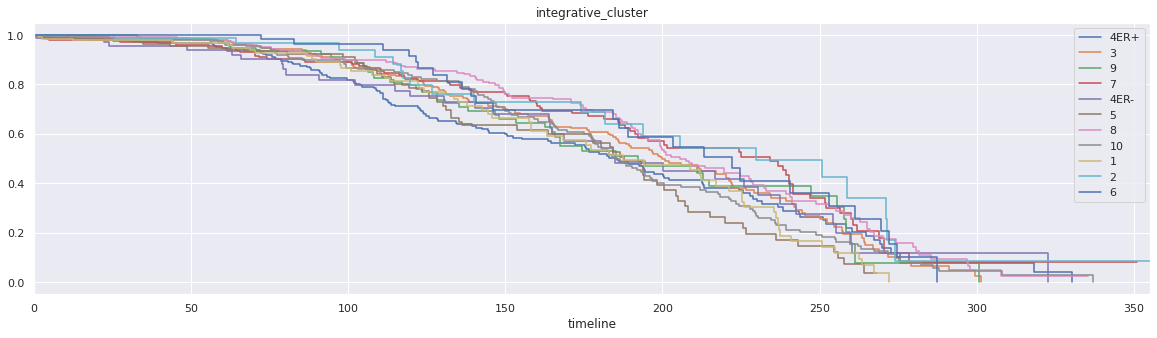

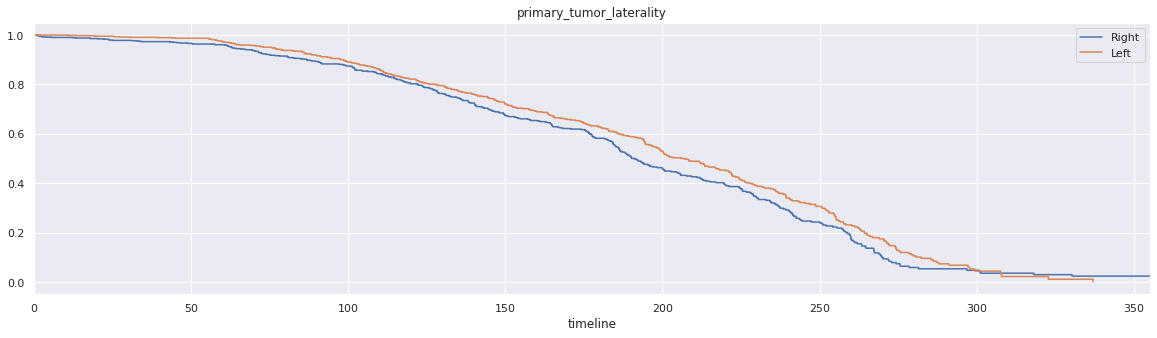

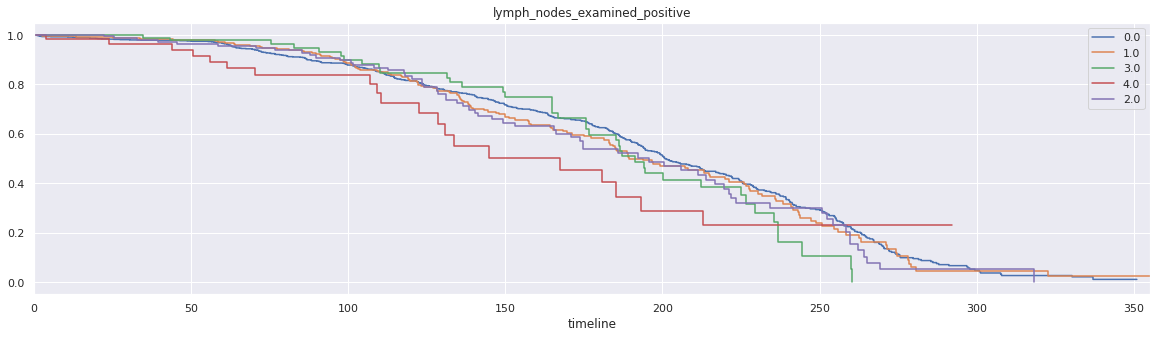

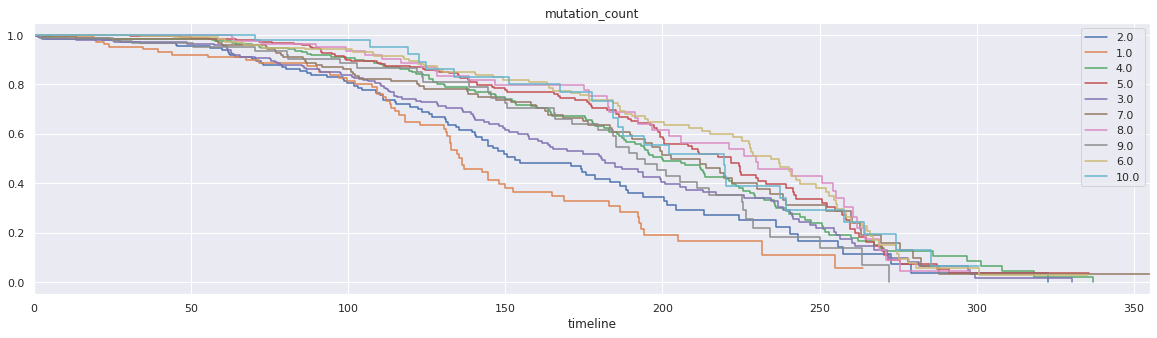

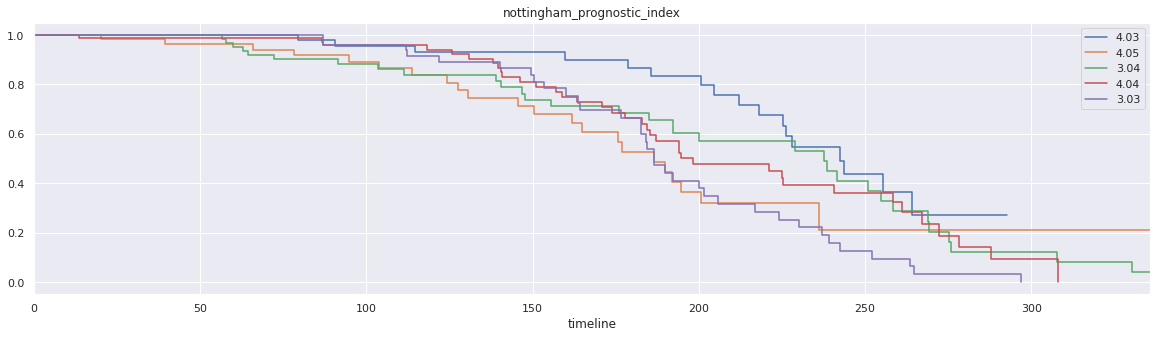

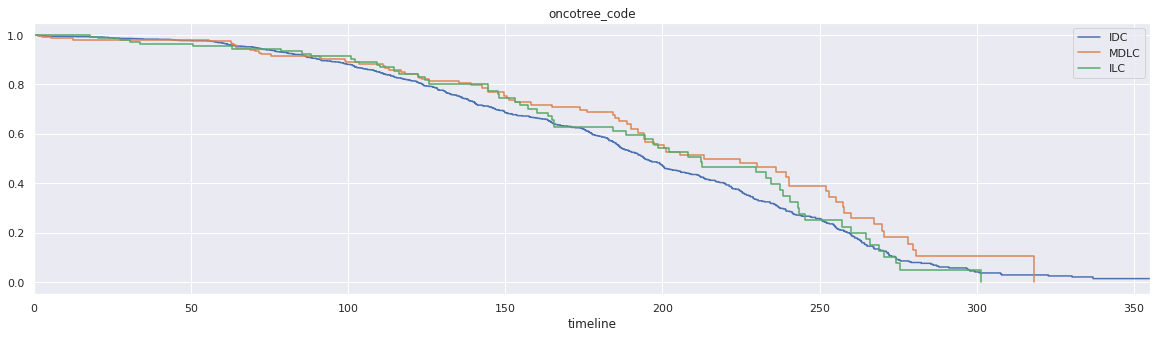

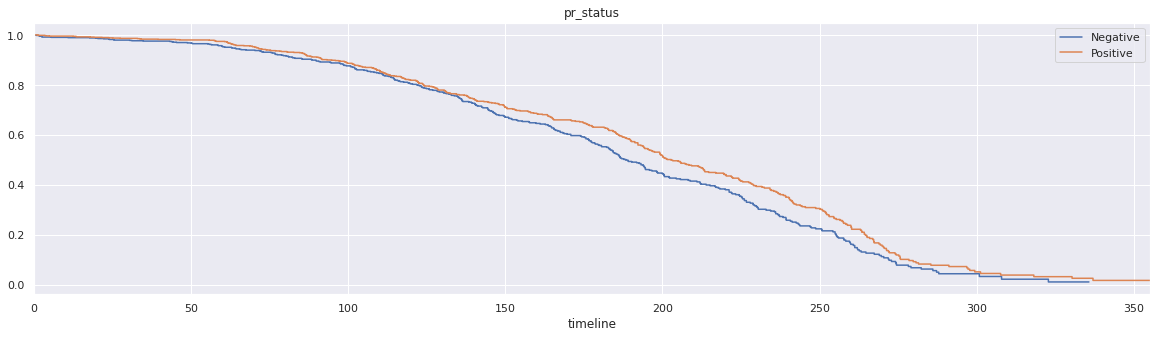

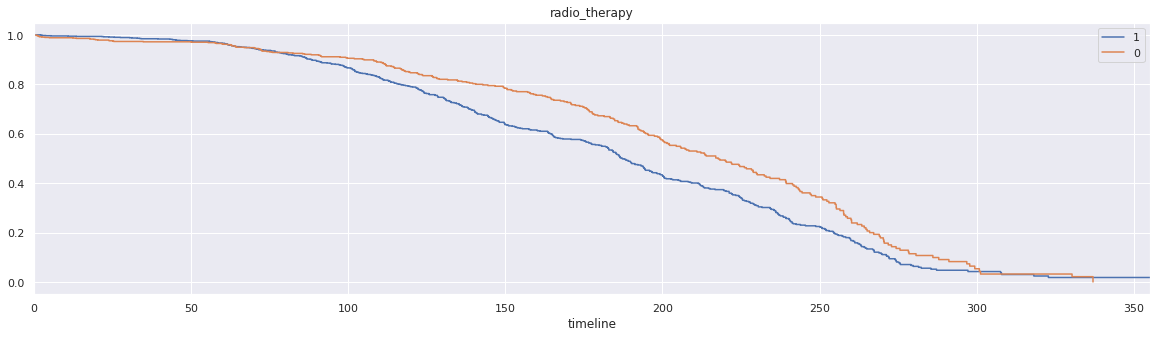

In [46]:
for c in ['her2_status', '3-gene_classifier_subtype', 'er_ihc', 'er_status',
       'tumor_other_histologic_subtype', 'hormone_therapy',
       'inferred_menopausal_state', 'integrative_cluster',
       'primary_tumor_laterality', 'lymph_nodes_examined_positive',
       'mutation_count', 'nottingham_prognostic_index', 'oncotree_code',
        'pr_status',
       'radio_therapy',          
         ]:
    plt.figure(figsize = (20,5))
    for v in df[c].unique(): #  ['claudin-low', 'LumA', 'LumB', 'Normal', 'Her2', 'Basal']:
        m = df[c] == v
        if m.sum() < 50: continue 
        T = df['overall_survival_months'][m] 
        E = df['overall_survival'][m]
        kmf = KaplanMeierFitter(label=v)
        kmf.fit(T,E)
        kmf.plot(ci_show=False)
        plt.title(c)

In [47]:
df.dropna(subset=['tumor_other_histologic_subtype'],inplace=True)

In [48]:
f = 'tumor_other_histologic_subtype'
print( df[f].unique() )
df[f].value_counts()

['Ductal/NST' 'Mixed' 'Lobular' 'Tubular/ cribriform' 'Mucinous'
 'Medullary' 'Other' 'Metaplastic']


Ductal/NST             1454
Mixed                   207
Lobular                 142
Medullary                25
Mucinous                 22
Tubular/ cribriform      21
Other                    17
Metaplastic               1
Name: tumor_other_histologic_subtype, dtype: int64

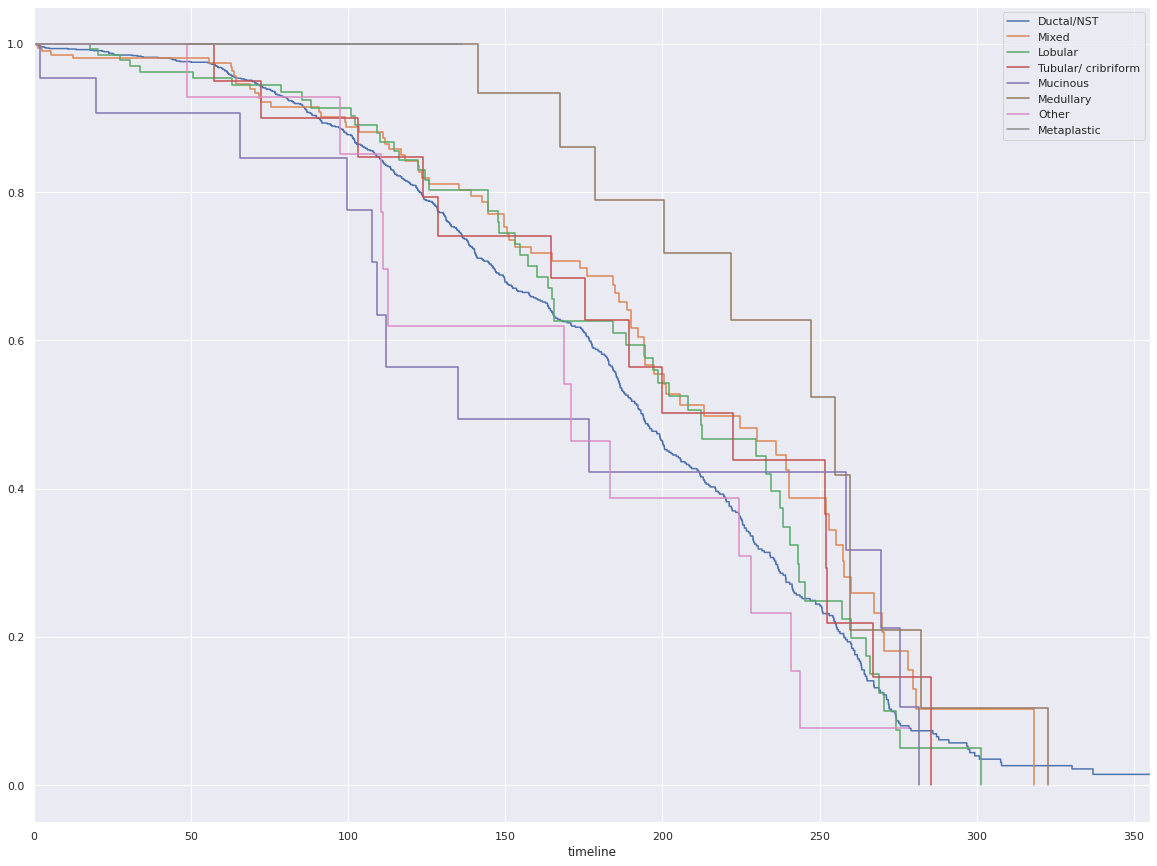

In [49]:
plt.figure(figsize = (20,15))
for v in ['Ductal/NST','Mixed','Lobular','Tubular/ cribriform' , 'Mucinous','Medullary','Other','Metaplastic']:

    m = df[f] == v

    T = df['overall_survival_months'][m] 

    E = df['overall_survival'][m]

    kmf = KaplanMeierFitter(label=v)                                                                                                                                                                                                                                                                                                   
    
    kmf.fit(T,E)
    kmf.plot(ci_show=False)

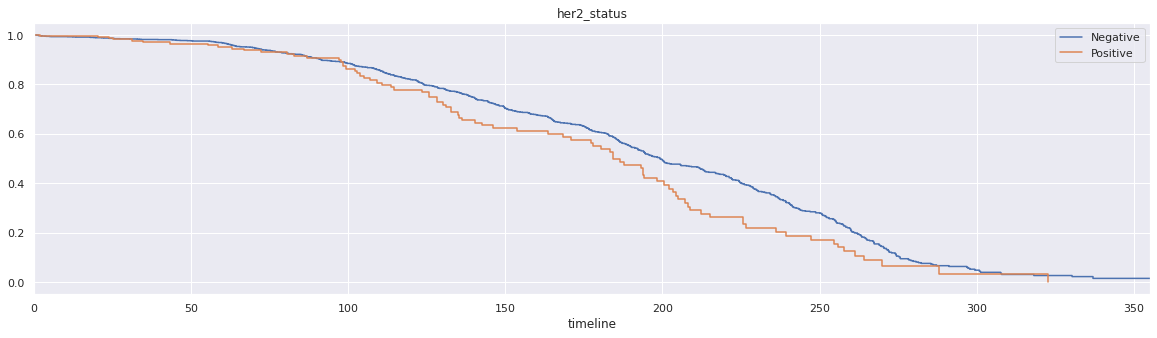

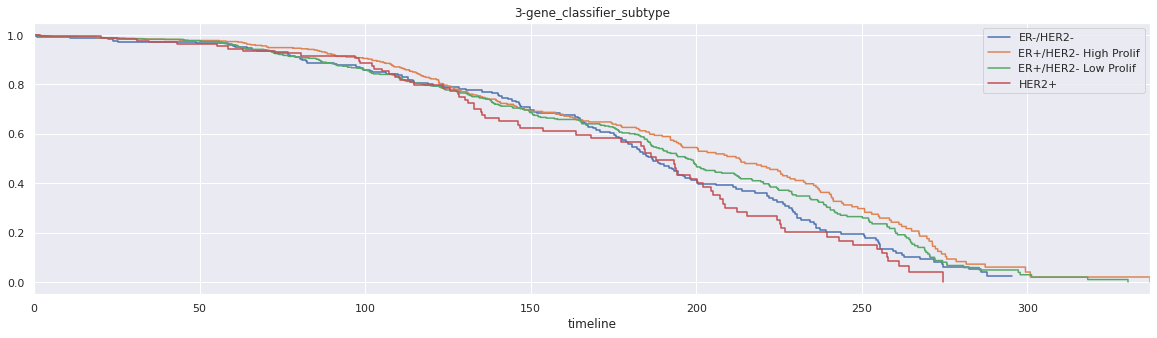

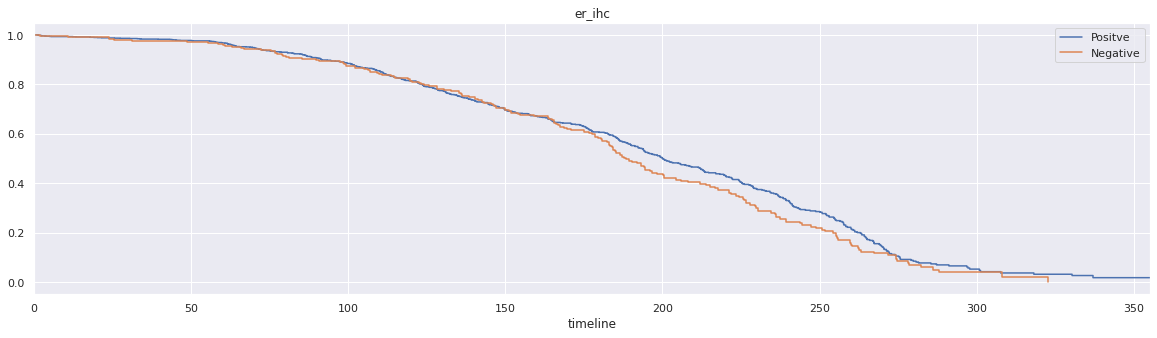

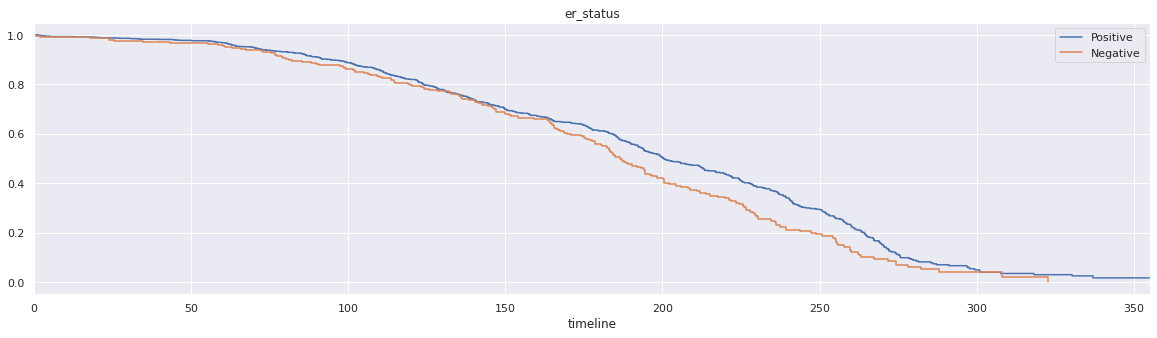

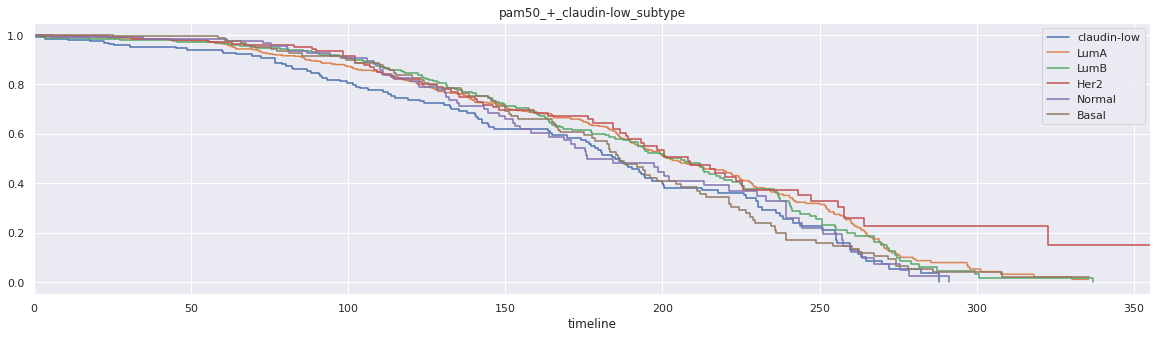

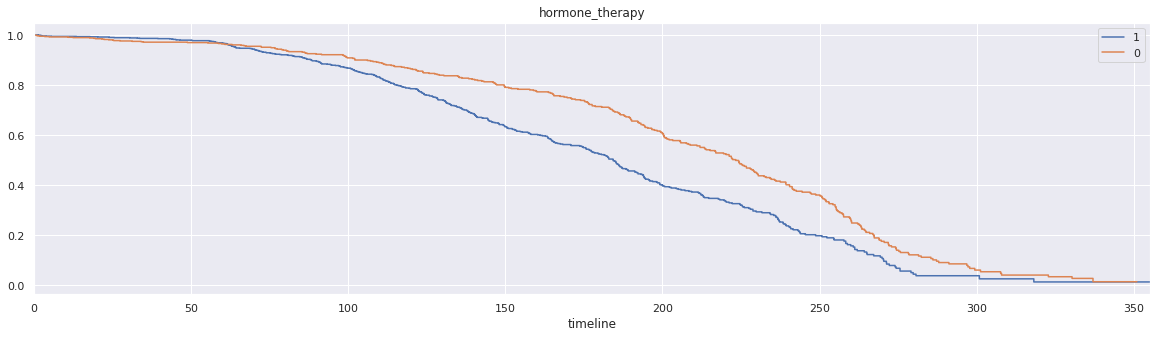

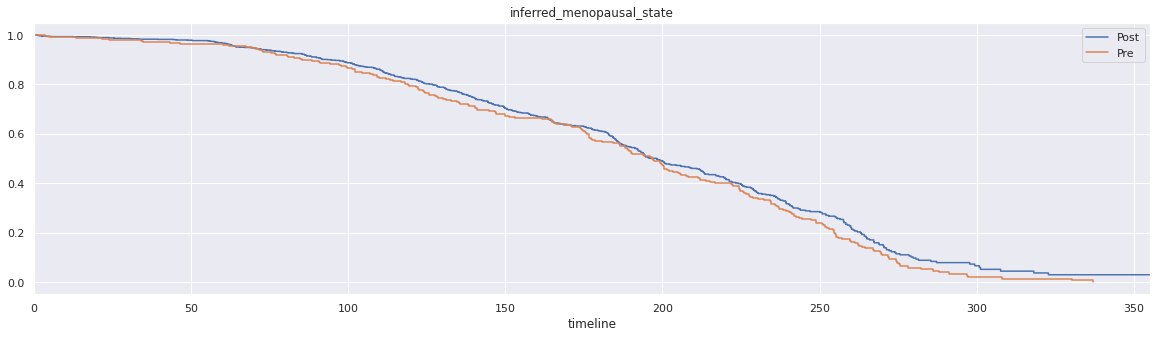

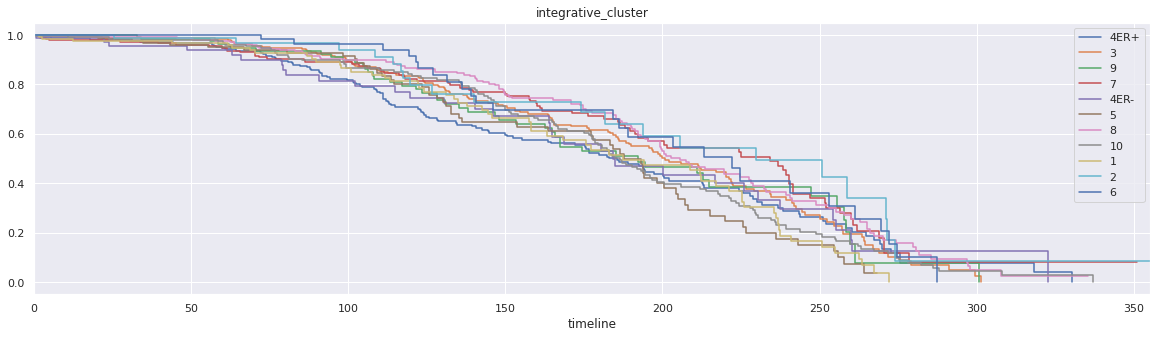

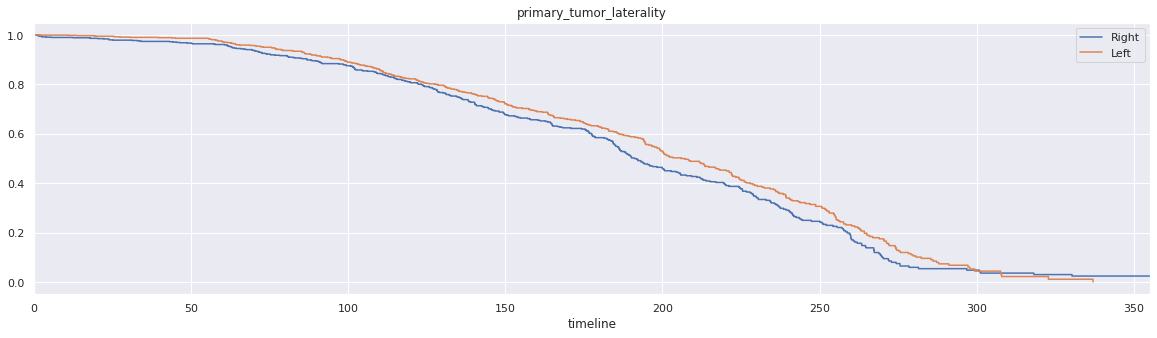

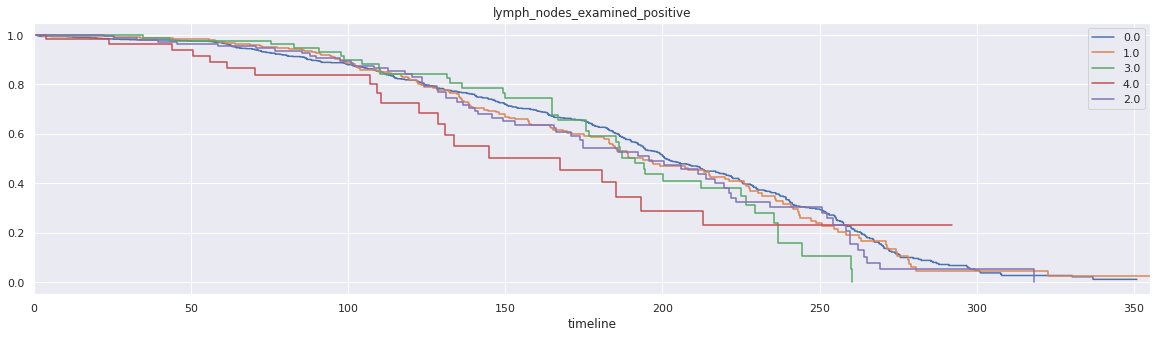

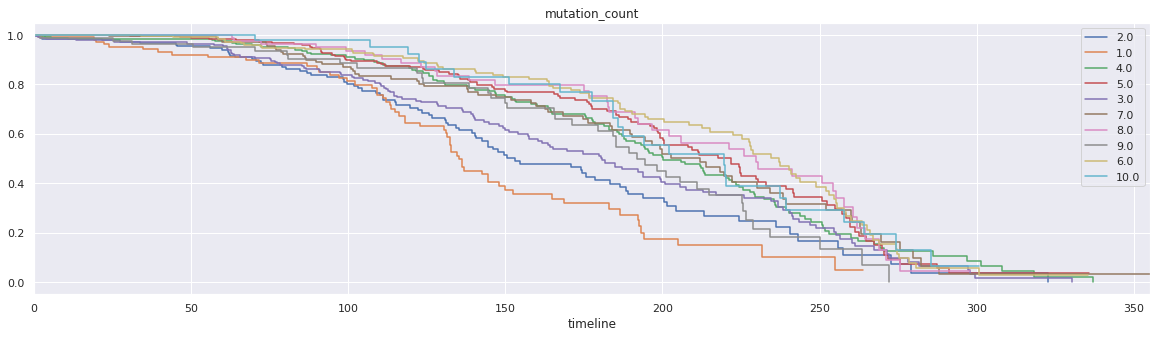

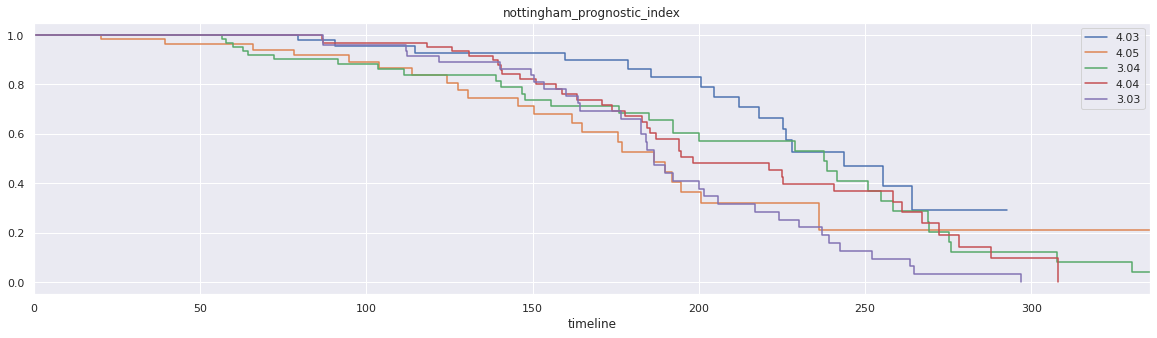

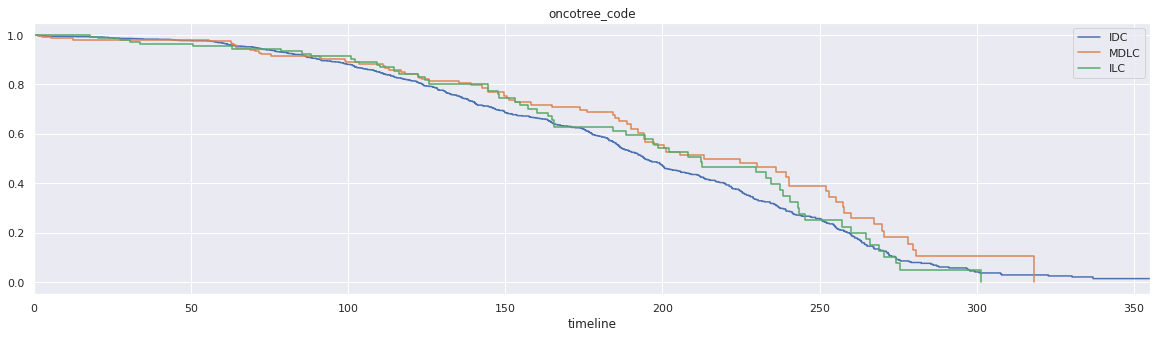

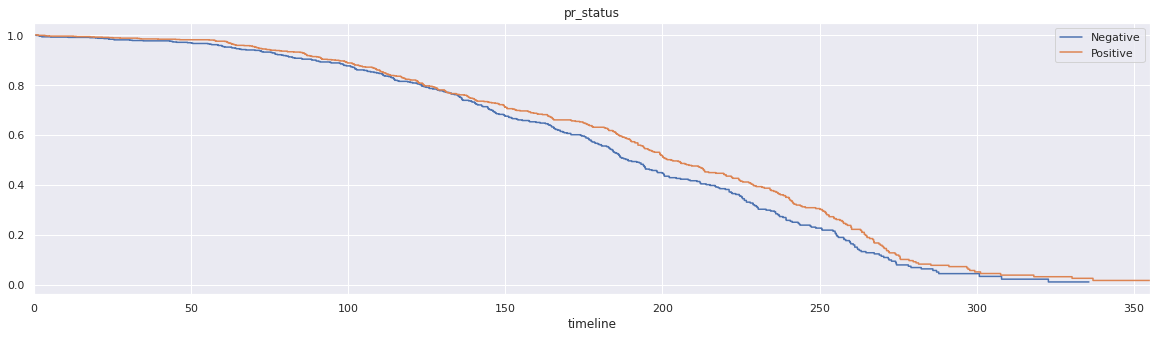

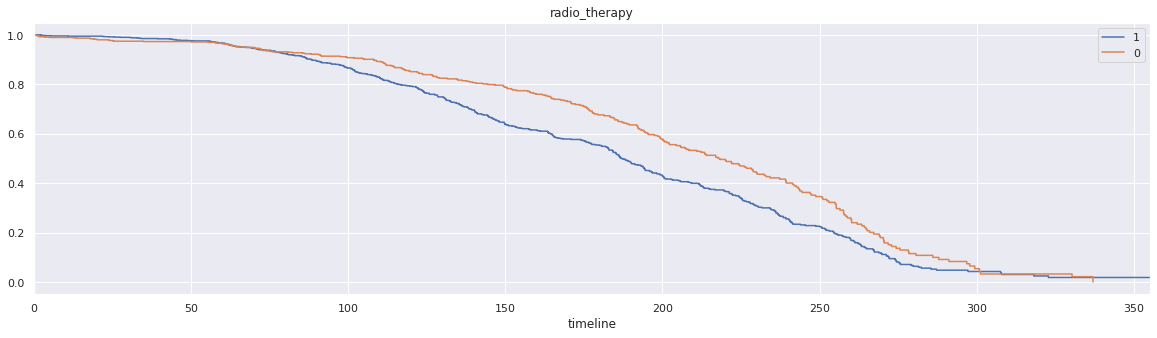

In [50]:
for c in ['her2_status', '3-gene_classifier_subtype', 'er_ihc', 'er_status',
       'pam50_+_claudin-low_subtype', 'hormone_therapy',
       'inferred_menopausal_state', 'integrative_cluster',
       'primary_tumor_laterality', 'lymph_nodes_examined_positive',
       'mutation_count', 'nottingham_prognostic_index', 'oncotree_code',
        'pr_status',
       'radio_therapy',          
         ]:
    plt.figure(figsize = (20,5))
    for v in df[c].unique(): #  ['Ductal/NST','Mixed','Lobular','Tubular/ cribriform' , 'Mucinous','Medullary','Other','Metaplastic']
        m = df[c] == v
        if m.sum() < 50: continue 
        T = df['overall_survival_months'][m] 
        E = df['overall_survival'][m]
        kmf = KaplanMeierFitter(label=v)
        kmf.fit(T,E)
        kmf.plot(ci_show=False)
        plt.title(c)

- The Initial stage is being steady with all the cells later on her2's survival is detoriating.
- The positive genes her2_status has the lowest survival rate and er_status has the highest survival rate for all the given subtypes.
- On the other hand, physical treatment/changes we get to perform on the young women with negative results after their surgeries and therapies have higher survival rate.

### **Evaluation Metrics:**

In [51]:
kmeans_model = KMeans(n_clusters = 4).fit(X)
labels = kmeans_model.labels_
silhouette_score(X, labels, metric = 'euclidean')

0.7320475791423923

In [52]:
prediction = pd.concat([X_train, Y], axis=1, join='inner')

In [53]:
#First group:
grouped_data1 = prediction.groupby(['Cluster']).get_group(0)

iqr_data_1 = np.array(grouped_data1['overall_survival_months'])
q3_cluster0, q1_cluster0 = np.percentile(iqr_data_1, [90 ,10])

#Second group:
grouped_data2 = prediction.groupby(['Cluster']).get_group(1)

iqr_data_2 = np.array(grouped_data2['overall_survival_months'])
q3_cluster1, q1_cluster1 = np.percentile(iqr_data_2, [90 ,10])

#Third group:
grouped_data3 = prediction.groupby(['Cluster']).get_group(2)

iqr_data_3 = np.array(grouped_data3['overall_survival_months'])
q3_cluster2, q1_cluster2 = np.percentile(iqr_data_3, [90 ,10])

#Fourth group:
grouped_data4 = prediction.groupby(['Cluster']).get_group(0)

iqr_data_4 = np.array(grouped_data4['overall_survival_months'])
q3_cluster3, q1_cluster3 = np.percentile(iqr_data_4, [90 ,10])

#Data:
x_test_clust = kmeans.predict(X_test)
cluster_array = np.array(x_test_clust)
survival_month_array = np.array(y_test)
overall_survival = np.array(X_test['overall_survival'])
cancer_type = np.array(X_test['death_from_cancer'])

correct = 0

for i in range(0, survival_month_array.size):
  if cluster_array[i] == 0:
    if survival_month_array[i] >= q1_cluster0 and survival_month_array[i] <= q3_cluster0:
      correct = correct + 1
  if cluster_array[i] == 1:
    if survival_month_array[i] >= q1_cluster1 and survival_month_array[i] <= q3_cluster1:
      correct = correct + 1    
  if cluster_array[i] == 2:
    if survival_month_array[i] >= q1_cluster2 and survival_month_array[i] <= q3_cluster2:
      correct = correct + 1    
  if cluster_array[i] == 3:
    if survival_month_array[i] >= q1_cluster3 and survival_month_array[i] <= q3_cluster3:
      correct = correct + 1     
print("Accuracy of clustered data fitting into range", (correct/survival_month_array.size)*100)

Accuracy of clustered data fitting into range 75.89453860640302


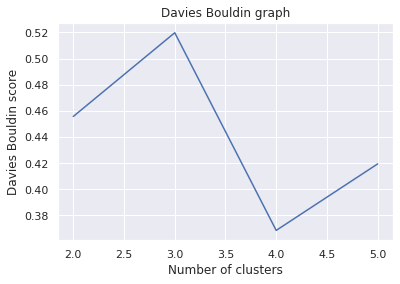

In [55]:
davies_bouldin=[]
for i in range(2,6): 
  kmeans = KMeans(n_clusters=i, init ='k-means++', max_iter=300,  n_init=10,random_state=0 )
  kmeans.fit(X)
  labels = kmeans.labels_
  davies_bouldin.append(davies_bouldin_score(X, labels))
plt.plot(range(2,6),davies_bouldin)
plt.title('Davies Bouldin graph')
plt.xlabel('Number of clusters')
plt.ylabel('Davies Bouldin score')
plt.show()

#### - silhouette_score : 0.7320475791423923
#### - Accuracy of clustered data fitting into range 75.89453860640302

### WORKING MODEL IMPLEMENTATION AND LOCAL DEPLOYMENT IN AZURE:

## Create trained model

In [72]:
X_withoutclust=X_train.drop(columns=['Cluster'],axis=1)

In [73]:
from sklearn.linear_model import Ridge
kk = Ridge().fit(X_withoutclust.values.tolist(), X_train["Cluster"].values.tolist())

In [74]:
from azureml.core import Run
import joblib
joblib.dump(kk,'model.pkl')

['model.pkl']

## Register Model

In [75]:
from azureml.core.model import Model

model = Model.register(model_path="model.pkl",
                       model_name="clustering_model",
                       description="Clustering Breast Cancer dataset",
                       workspace=ws)

Registering model clustering_model


## Create Environment

In [76]:
import sklearn

from azureml.core.environment import Environment

environment = Environment("LocalDeploy")
environment.python.conda_dependencies.add_pip_package("inference-schema[numpy-support]")
environment.python.conda_dependencies.add_pip_package("joblib")
environment.python.conda_dependencies.add_pip_package("scikit-learn=={}".format(sklearn.__version__))

## Provide the Scoring Script

In [77]:
%%writefile score.py
import joblib
import json
import numpy as np
import os
import math


from inference_schema.schema_decorators import input_schema, output_schema
from inference_schema.parameter_types.numpy_parameter_type import NumpyParameterType

def init():
    global model
    # AZUREML_MODEL_DIR is an environment variable created during deployment.
    # It is the path to the model folder (./azureml-models/$MODEL_NAME/$VERSION)
    # For multiple models, it points to the folder containing all deployed models (./azureml-models)
    model_path = os.path.join(os.getenv('AZUREML_MODEL_DIR'), 'model.pkl')
    # Deserialize the model file back into a sklearn model.
    model = joblib.load(model_path)
    

input_sample = np.array([[6133,74.6,0,5.0,2.0,0,0.0,7.0,3.078,0,0,39.0,1,2,0,2,1,1,2,0,1,0,3,1,2,0,0,0]])
output_sample = np.array([3])
@input_schema('X_train', NumpyParameterType(input_sample))
@output_schema(NumpyParameterType(output_sample))
def run(X_train):
    try:
        result =model.predict(X_train)
        # You can return any JSON-serializable object.
        return result.tolist()
    except Exception as e:
        error = str(e)
        return error        

Overwriting score.py


## Create Inference Configuration

In [78]:
from azureml.core.model import InferenceConfig

inference_config = InferenceConfig(entry_script="score.py",
                                   environment=environment)

## Deploy Model as a Local Docker Web Service

In [79]:
from azureml.core.webservice import LocalWebservice
# This is optional, if not provided Docker will choose a random unused port.
deployment_config = LocalWebservice.deploy_configuration(port=6779)
local_service = Model.deploy(ws,'clusteringmodel1',[model],inference_config,deployment_config)
local_service.wait_for_deployment()

Generating Docker build context.
Package creation Succeeded
Logging into Docker registry 9b30e7a499db43b39f418f848ceb7bf7.azurecr.io
Logging into Docker registry 9b30e7a499db43b39f418f848ceb7bf7.azurecr.io
Building Docker image from Dockerfile...
Step 1/5 : FROM 9b30e7a499db43b39f418f848ceb7bf7.azurecr.io/azureml/azureml_3c337f053d15842de385eb6a30c42a13
 ---> 41fcd0419f36
Step 2/5 : COPY azureml-app /var/azureml-app
 ---> 29b901a63ef1
Step 3/5 : RUN mkdir -p '/var/azureml-app' && echo eyJhY2NvdW50Q29udGV4dCI6eyJzdWJzY3JpcHRpb25JZCI6IjdkZjAyNGM2LTRhNDYtNDUwOS1hODYyLTUwZGM3MzliZmZhMiIsInJlc291cmNlR3JvdXBOYW1lIjoiZmluYWxwcm9qZWN0IiwiYWNjb3VudE5hbWUiOiJzaHdldGhhc21sIiwid29ya3NwYWNlSWQiOiI5YjMwZTdhNC05OWRiLTQzYjMtOWY0MS04Zjg0OGNlYjdiZjcifSwibW9kZWxzIjp7fSwibW9kZWxzSW5mbyI6e319 | base64 --decode > /var/azureml-app/model_config_map.json
 ---> Running in 095870bc6ffe
 ---> 6f5d949e56a4
Step 4/5 : RUN mv '/var/azureml-app/tmpd7lwgawt.py' /var/azureml-app/main.py
 ---> Running in ed53ccbb1d5f
 -

In [80]:
print('Local service port: {}'.format(local_service.port))

Local service port: 6779


## Check Status and Get Container Logs

In [81]:
print(local_service.get_logs())

2021-12-28T18:29:35,930663006+00:00 - gunicorn/run 
2021-12-28T18:29:35,930692606+00:00 - iot-server/run 
2021-12-28T18:29:35,935935865+00:00 - rsyslog/run 
Dynamic Python package installation is disabled.
Starting HTTP server
2021-12-28T18:29:35,942149834+00:00 - nginx/run 
EdgeHubConnectionString and IOTEDGE_IOTHUBHOSTNAME are not set. Exiting...
2021-12-28T18:29:36,010499798+00:00 - iot-server/finish 1 0
2021-12-28T18:29:36,011990615+00:00 - Exit code 1 is normal. Not restarting iot-server.
Starting gunicorn 20.1.0
Listening at: http://127.0.0.1:31311 (14)
Using worker: sync
worker timeout is set to 300
Booting worker with pid: 41
SPARK_HOME not set. Skipping PySpark Initialization.
Initializing logger
2021-12-28 18:29:36,468 | root | INFO | Starting up app insights client
logging socket was found. logging is available.
logging socket was found. logging is available.
2021-12-28 18:29:36,468 | root | INFO | Starting up request id generator
2021-12-28 18:29:36,468 | root | INFO | Star

## Test Web Service

We can enter the data to test as a part of the dataframe by taking a sample (group of rows) or even test specific (single) rows with the patient id

In [112]:
df_new = X_withoutclust.iloc[2:4]

In [64]:
df_new = X_withoutclust.query("patient_id==6133")

In [113]:
df_new

,patient_id,age_at_diagnosis,chemotherapy,cohort,neoplasm_histologic_grade,hormone_therapy,lymph_nodes_examined_positive,mutation_count,nottingham_prognostic_index,overall_survival,...,her2_next_generation_sequencing,her2_status,tumor_other_histologic_subtype,inferred_menopausal_state,integrative_cluster,primary_tumor_laterality,oncotree_code,pr_status,3-gene_classifier_subtype,death_from_cancer
1495,5651,51.98,1,3.0,3.0,1,1.0,7.0,5.052,0,...,2,0,4,0,3,1,5,0,2,0
1540,6071,72.81,0,5.0,2.0,1,7.0,9.0,5.068,0,...,2,0,0,0,8,0,1,1,0,0


In [111]:
X_train.iloc[2:4]

,patient_id,age_at_diagnosis,chemotherapy,cohort,neoplasm_histologic_grade,hormone_therapy,lymph_nodes_examined_positive,mutation_count,nottingham_prognostic_index,overall_survival,...,her2_status,tumor_other_histologic_subtype,inferred_menopausal_state,integrative_cluster,primary_tumor_laterality,oncotree_code,pr_status,3-gene_classifier_subtype,death_from_cancer,Cluster
1495,5651,51.98,1,3.0,3.0,1,1.0,7.0,5.052,0,...,0,4,0,3,1,5,0,2,0,2
1540,6071,72.81,0,5.0,2.0,1,7.0,9.0,5.068,0,...,0,0,0,8,0,1,1,0,0,1


##### The cluster values are **2 and 1**

In [103]:
df_new=X_test.sample(1)

We can also use the **TEST DATA** (X_test) TO MAKE NEW PREDICTIONS with the web service

In [114]:
import json
#X_train= X_train.to_json()
sample_input = json.dumps({
    'X_train': df_new.values.tolist()
})
ans=local_service.run(sample_input)
import math
print(ans)
for i in ans: 
    an_integer = round(i)
    print("The patient belongs to cluster ",an_integer)

[2.0991049162382804, 0.6597546214720458]
The patient belongs to cluster  2
The patient belongs to cluster  1


**The model also predicts 2 and 1**

#### When we compare the already predicted cluster values and the deployed model's prediction, we can find that they are the same.Thus, the deployment is successful. 